# DELPHI on PS-Booster HOM impedance & comparison from PyHEADTAIL
Parameters from Eirini Koukovini Platia

## Imports and parameters

### Imports

In [1]:
%matplotlib notebook

In [2]:
from string import *
import time
import numpy as np
import scipy
from copy import deepcopy
import os,re,shutil,json
from io_lib import *
from tables_lib import select_in_table
from plot_lib import set_fontsize,scix,sciy
from particle_param import *
from Impedance import *
from DELPHI import *
from LHC_param import *
from LHC_imp import *
from LHC_coll_imp import *
import pickle as pkl
import inspect
import pyoptics as opt
import csv
from octupole import detuning_coeff,detuning_bx_bxy,find_octupole_threshold
import pytimber
from datetime import datetime
from collections import OrderedDict
from matplotlib import pyplot as plt
import warnings
from glob import glob
from toolbox.machine_toolbox import particle_parameters, synchrotron
warnings.simplefilter('ignore')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Functions to get signal at a pickup (from D. Amorim)

In [3]:
def R_computation_v2(eigenvector, ldown, lup, nmax, r, a, b, taub, beta=1):
    ''' Computes R(tau) as defined in as in N. Mounet, "DELPHI_expanded", slide 22
    
    Inputs
    ======
    - eigenvector: numpy array
        The mode eigenvector computed with DELPHI
    - ldown: int
        The lowest azimuthal mode number computed
    - lup: int
        The highest azimuthal mode number computed
    - nmax: int
        The number of radial modes computed
    - r: numpy array
        The time sampling of the signal
    - a, b: floats
        The coefficient given by DELPHI.py function longdistribution_decomp
        For a Gaussian distribution, a = b = 8
    - taub: float
        Bunch length in seconds
    - beta: float (between 0 and 1)
        Particle speed w.r.t to light speed
    
    Outputs
    =======
    - Rl_table: numpy array
    
    Example
    =======
    tau = np.linspace(0, 4.0e-9, 1000)
    r = 299792458 * beta * tau

    # For standard DELPHI simulations, we have lup = -ldown = nmax
    # The values can therefore be found from the size of the eigenvector array
    # For example we can have (ldown, lup, nmax) = (-1, 1, 1) ... (-15, 15, 15)
    
    lmax = ((-3 + np.sqrt(9 - 8*(1.0 - len(eigenvector))))/4).astype(int)
    lup = lmax
    ldown = -lmax
    nmax = lmax

    Rl_table = R_computation_v2(eigenvector, ldown, lup, nmax, r, a, b, SPS.taub, SPS.beta)   
    
    '''


    clight = 299792458
    #Rl is an interdemediate variable for the calculations, see N. Mounet, slide 39
    #Rl_table contains the Rl for all the l from lmax to -lmax-1
    Rl = np.zeros(len(r), dtype=complex)
    Rl_table = np.zeros(((lup-ldown+1), len(r)), dtype=complex)

    #Rsum contains the result of the addition of all Rl
    Rsum = np.zeros(len(r), dtype=complex)
    
    #First the computation of each Rl
    for l in range(lup,ldown-1,-1):

        for n in range(nmax+1):
                        
            Rl += (eigenvector[n + (l-ldown)*(nmax+1)]
                   * scipy.special.eval_genlaguerre(n, abs(l), a * ((r / (beta*clight*taub))) ** 2))

        Rl *= (r / (beta*clight*taub)) ** abs(l) * np.exp(-b * ((r / (beta*clight*taub))) ** 2)

        #Each Rl is stored then erased
        Rl_table[l-ldown, :] = Rl

        Rl = np.zeros(len(r),dtype=complex)
       
    return Rl_table


def headtail_signal(Rl_table, max_freq, nb_points, lup, ldown, eigenvalue,
                    r, tune, Qp, eta, radius, beta=1, n_signals=10):
    '''
    Inputs
    ======
    - Rl_table: numpy array
        Table with Rl values, computed with the R_computation_v2 function
    - max_freq: float
        Maximum frequency of the sampling (in Hz)
    - nb_points: int
        Number of points in the frequency sampling
    - lup, ldown: int
        The lowest and highest azimuthal mode numbers computed by DELPHI
    - eigenvalue: complex
        The eigenvalue of the mode investigated
    - r: numpy array
        The time sampling of the signal
    - tune: float
        The beam tune
    - Qp: float
        The beam chromaticity (in unnormalized units)
    - eta: float
        Beam slippage factor
    - radius: float
        machine radius
    - beta: float (between 0 and 1)
        Particle speed w.r.t to light speed
    -n_signals: int
        Number of headtail traces to compute
        
    Outputs
    =======
    - freq = omega/(2*np.pi): numpy array
        Signal spectrum frequency array
    - lamba1tot: numpy array
        Complex signal spectrum
    - time: numpy array
        Time domain signal times
    - list_signals: numpy array
        List of time domain signals
        
        
    Example
    =======
    # the sampling
    tau = np.linspace(0, 4.0e-9, 500)
    r = 299792458 * beta * tau

    # For standard DELPHI simulations, we have lup = -ldown = nmax
    # The values can therefore be found from the size of the eigenvector array
    # For example we can have (ldown, lup, nmax) = (-1, 1, 1) ... (-15, 15, 15)
    lmax = ((-3 + np.sqrt(9 - 8*(1.0 - len(eigenvector))))/4).astype(int)
    lup = lmax
    ldown = -lmax
    nmax = lmax

    Rl_table = R_computation_v2(eigenvector, ldown, lup, nmax, r, a, b, SPS.taub)

    max_freq = 5e9
    n_signals = 10

    freq, lambda1tot, time, list_signals = headtail_signal_plot(Rl_table, max_freq=max_freq,
                                                                 nb_points=300, lup=lup, ldown=ldown,
                                                                 eigenvalue=eigenvalue, r=r, tune=SPS.Qx,
                                                                 Qp=0, eta=SPS._eta, radius=SPS.radius, beta=SPS.beta,
                                                                 n_signals=n_signals)
    
    import matplotlib.pyplot as plt

    #First plot shows the spectrum
    plt.figure()
    plt.xlim([-max_freq, max_freq])
    plt.plot(freq, np.real(lambda1tot), '-r')
    plt.plot(freq, np.imag(lambda1tot), '-b')
    plt.xlabel('Frequency / Hz')

    #Second plot shows a serie of signals
    plt.figure()
    for ii in np.arange(0, n_signals, 1):
        plt.plot(time, list_signals[ii], '-')

    plt.xlim(-6 * SPS.taub/4, 6 * SPS.taub/4)
    plt.xlabel('Bunch length / ns')
    plt.ylabel('Signal amplitude / arb. unit')
    '''


    c = 299792458
    omega = 2 * np.pi * np.linspace(-max_freq, max_freq, nb_points)

    lambda1 = np.zeros(len(omega), dtype=complex)
    lambda1tot = np.zeros(len(omega), dtype=complex)

    for i in range(0, len(omega)):
        for l in range(lup, ldown-1, -1):
            lambda1[i] = np.trapz(r*Rl_table[l-ldown]*2*np.pi*(-1.0j)**(-l)
                                  *scipy.special.jn(l,(eigenvalue + omega[i])
                                                    *r/(beta*c) - Qp*r/(eta * radius)), r)
            lambda1tot[i] += lambda1[i]

            
    list_signals = []        
    for ii in np.arange(0, n_signals, 1):
        # sig_lambda = lambda1tot*np.exp(ii*1j*2*np.pi*(machine.Qxfrac+eigenvalues_converged[Qpindex][EValue_number]/omega0))
        # signal = np.fft.ifft(sig_lambda+np.conj(sig_lambda))
        signal = np.fft.ifft(np.fft.fftshift(lambda1tot))*np.exp(ii*1j*2*np.pi*tune)
        # signal = np.fft.ifft(np.fft.fftshift(lambda1tot))
        # signal = signal[0::2]

        #freq = np.fft.fftfreq(tau.shape[-1])

        n = signal.size
        time = np.fft.fftfreq(n, d=np.diff(omega/2/np.pi)[0])
        ind = np.argsort(time)
        list_signals.append((np.abs(signal) * np.cos(np.angle(signal)))[ind])

    return omega/(2*np.pi), lambda1tot, time[ind], list_signals

### Parameters

In [4]:
electron, m0, clight, E0 = proton_param()
machine_name = 'PSB'
ResultDir = '/home/nimounet/cernbox/Simulations/DELPHI/{}/HOM'.format(machine_name)
os.system("mkdir -p "+ResultDir)

# flags and numerical parameters
flagdamperimp = 0 # 1 to use frequency dependent damper gain (provided in d,freqd)
d = None
freqd = None
strnorm = ['']
flagnorm = 0 # 1 if damper matrix normalized at current chromaticity (instead of at zero chroma)
nevery = 1 # downsampling of the impedance (take less points than in the full model)
flagm0 = True
flageigenvect = False
#queue = '2nd' # LXBATCH queue (converted in DELPHI to a ht_condor one)

In [5]:
parameter_file = './PS_Booster_160MeV.yaml'
machine = synchrotron.Synchrotron(parameter_file)
with open(parameter_file,'r') as f:
    print f.read()
#machine.omegas=machine.Qs*machine.omega0
particle = machine.particle

#print machine.omega0, machine.f0, machine.omegas, machine.Qs, machine.Qx, machine.Qy, machine.eta, machine.taub
#print 'Q_s = ', machine.Qs
#print 'taub = ', machine.taub

Momentum compaction factor not attributed yet, pass slippage factor computation
Ring Parameters:
    name: PS_Booster
    year: 2018
    state: injection
    circumference: 157.07
Beam Parameters:
    particle_name: Proton
    E_kinetic: 160.e+6
    harmonic: 1
    RF_voltage: 8.e+3
    Qs: 0.0016953
    taub: 480.0e-9
    en: 2.5e-6 # normalized emittance
    Qx: 4.26
    Qy: 4.2
    alphap: 0.06016
    synchrotron_phase: 0.



## Generate impedance

<IPython.core.display.Javascript object>


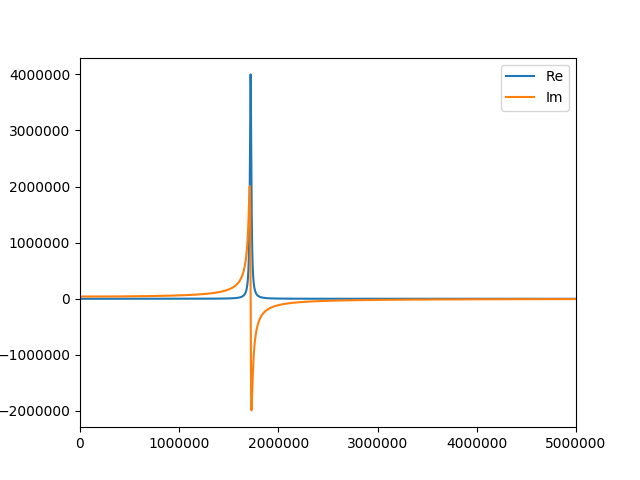

In [6]:
imp_mod, _ = imp_model_resonator(Rlist=4e6,frlist=1.72e6,Qlist=100,beta=machine.beta,
                                 fpar=freq_param(fmin=0,fmax=5e6,ftypescan=1,fsamplin=5e2,fadded=[]),
                                 listcomp=['Zxdip'])

plt.figure()
plt.plot(imp_mod[0].var, imp_mod[0].func[:,0], label='Re')
plt.plot(imp_mod[0].var, imp_mod[0].func[:,1], label='Im')
plt.xlim(0, 5e6)
plt.legend()
plt.show()

## Old DELPHI calculation (scan in Qx)
It fails miserably

In [34]:
g, a, b = longdistribution_decomp(machine.taub, typelong='Gaussian')

print "Qy= {}, omega0={}, Qs= {}, gamma={}, eta={}, taub={}".format(machine.Qy,machine.omega0,machine.Qs,
                                                                    machine.gamma,machine._eta,machine.taub)

kmax = 1 # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot = 50; # number of kept and plotted eigenvalues (in TMCI plot)
# DELPHI convergence criteria
crit = 5e-2
abseps = 1e-4
#flag_trapz = 0

# Chromaticity
#Qp = -3.5#-0.73*machine.Qx  # horizontal chroma
#omegaksi = Qp*machine.omega0 / machine._eta

# Number of bunches
M = 1
# Damper gain and phase
damp = 0.0
dphase = 0
# Intensity scan
#Nbscan = np.arange(0, 5.2e11, 2e10)
Nbscan = [4e12]
Qxscan = np.arange(4.17, 4.49, 0.01)# 4.10, 4.45, 0.01)

tuneshifts = []
#eigenvectors = []

scenario = 'Eirini_old_DELPHI'

for Qx in Qxscan:
    
    print "="*60
    Qp = -0.73*Qx
    omegaksi = Qp*machine.omega0 / machine._eta
    print machine._eta
    dQ, _ = DELPHI_wrapper(imp_mod, [M], [Qp], [damp], Nbscan, [machine.omegas], [dphase], machine.omega0,
                           Qx, machine.Qy, machine.gamma, machine._eta, a, b, machine.taub, g, ['x'],
                           nevery=nevery, particle='proton', flagnorm=flagnorm, flagdamperimp=flagdamperimp,
                           d=d, freqd=freqd, kmax=kmax, kmaxplot=kmaxplot,
                           crit=crit, abseps=abseps, flagm0=flagm0, flageigenvect=flageigenvect,
                           lxplusbatch=None, comment="{}_{}_{}".format(machine_name,scenario,float_to_str(Qx)),
                           queue='2nd', dire=ResultDir+'/', flagQpscan_outside=True)
    
    print "Qx={}, Qpx={}: most unstable mode dQ={}".format(Qx,Qp,np.squeeze(dQ)[0])
    tuneshifts.append(dQ)
    #eigenvectors.append(v)

Qy= 4.2, omega0=6233102.82351, Qs= 0.0016953, gamma=1.17052622918, eta=-0.669696870079, taub=4.8e-07
-0.669696870079


UnboundLocalError: local variable 'eigenval' referenced before assignment

## Old DELPHI calculation with flag_trapz=0 (scan in Qx)

In [75]:
reload(sys.modules['DELPHI'])
from DELPHI import *

In [82]:
g, a, b = longdistribution_decomp(machine.taub, typelong='Gaussian')

print "Qy= {}, omega0={}, Qs= {}, gamma={}, eta={}, taub={}".format(machine.Qy,machine.omega0,machine.Qs,
                                                                    machine.gamma,machine._eta,machine.taub)

kmax = 1 # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot = 50; # number of kept and plotted eigenvalues (in TMCI plot)
# DELPHI convergence criteria
crit = 5e-2
abseps = 1e-4
flag_trapz = 0

# Chromaticity
#Qp = -3.5#-0.73*machine.Qx  # horizontal chroma
#omegaksi = Qp*machine.omega0 / machine._eta

# Number of bunches
M = 1
# Damper gain and phase
damp = 0.0
dphase = 0
# Intensity scan
#Nbscan = np.arange(0, 5.2e11, 2e10)
Nbscan = [4e12]
Qxscan = np.arange(4.17, 4.49, 0.01)# 4.10, 4.45, 0.01)
Qxscan = np.arange(4.23, 4.35, 0.01)# 4.10, 4.45, 0.01)

tuneshifts = []
#eigenvectors = []

scenario = 'Eirini_old_DELPHI'

result_folder = os.path.join(ResultDir,scenario)
os.system("mkdir -p "+result_folder)

DELPHI_params = {'Mscan': [M],
                 'Qxscan': Qxscan.tolist(),
                 'Qpscan': (-0.73*Qxscan).tolist(),
                 'dampscan': [damp],
                 'Nbscan': Nbscan,
                 'omegasscan': [machine.omegas],
                 'dphasescan': [dphase],
                 'omega0': machine.omega0,
                 'Qy': machine.Qy,
                 'gamma': machine.gamma, 'eta': machine._eta,
                 'a': a,'b': b,
                 'taub': machine.taub, 'g': g.tolist(),
                 'planes': ['x'],
                 'nevery': nevery,
                 'particle': 'proton',
                 'flagnorm': flagnorm,'flagdamperimp': flagdamperimp,
                 'd': d, 'freqd': freqd,
                 'kmax': kmax, 'kmaxplot': kmaxplot,
                 'crit': crit, 'abseps': abseps, 
                 'flagm0': flagm0, 'flageigenvect': flageigenvect,
                 'flag_trapz': flag_trapz,
                 'lxplusbatch': None,
                 'comment': "{}_{}".format(machine_name,scenario),
                 'queue': '2nd', 'dire': result_folder+'/',
                 'flagQpscan_outside': True,
                 }

with open(os.path.join(result_folder,'DELPHI_parameters.json'), 'w') as f:
    f.write(json.dumps(DELPHI_params,indent=4))

print (machine.taub / 4) * machine.beta * clight
t0 = ti.clock()
for Qx in Qxscan:
    
    print "="*60
    Qp = -0.73*Qx
    #Qp = -3.5
    dQ, _ = DELPHI_wrapper(imp_mod, [M], [Qp], [damp], Nbscan, [machine.omegas], [dphase], machine.omega0,
                           Qx, machine.Qy, machine.gamma, machine._eta, a, b, machine.taub, g, ['x'],
                           nevery=nevery, particle='proton', flagnorm=flagnorm, flagdamperimp=flagdamperimp,
                           d=d, freqd=freqd, kmax=kmax, kmaxplot=kmaxplot, flag_trapz=0,
                           crit=crit, abseps=abseps, flagm0=flagm0, flageigenvect=flageigenvect,
                           lxplusbatch=None, comment="{}_{}_{}".format(machine_name,scenario,float_to_str(Qx)),
                           queue='2nd', dire=result_folder+'/', flagQpscan_outside=True)
    
    print "Qx={}, Qpx={}: most unstable mode dQ={}".format(Qx,Qp,np.squeeze(dQ)[0])
    tuneshifts.append(dQ)
    #eigenvectors.append(v)

t1 = ti.clock()
print("Elapsed time: {} s".format(t1-t0))

Qy= 4.2, omega0=6233102.82351, Qs= 0.0016953, gamma=1.17052622918, eta=-0.669696870079, taub=4.8e-07
18.6981617627037
Qp= -3.0879000000000003 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.23, Qpx=-3.0879: most unstable mode dQ=(0.00173199331087-9.22864411547e-06j)
Qp= -3.0952 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.24, Qpx=-3.0952: most unstable mode dQ=(0.00174407244598-1.68226353149e-05j)
Qp= -3.1025 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.25, Qpx=-3.1025: most unstable mode dQ=(0.00176394285218-3.8072473389e-05j)
Qp= -3.1098 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.26, Qpx=

### Plot rise times vs Qx, and comparison with PyHEADTAIL

<IPython.core.display.Javascript object>


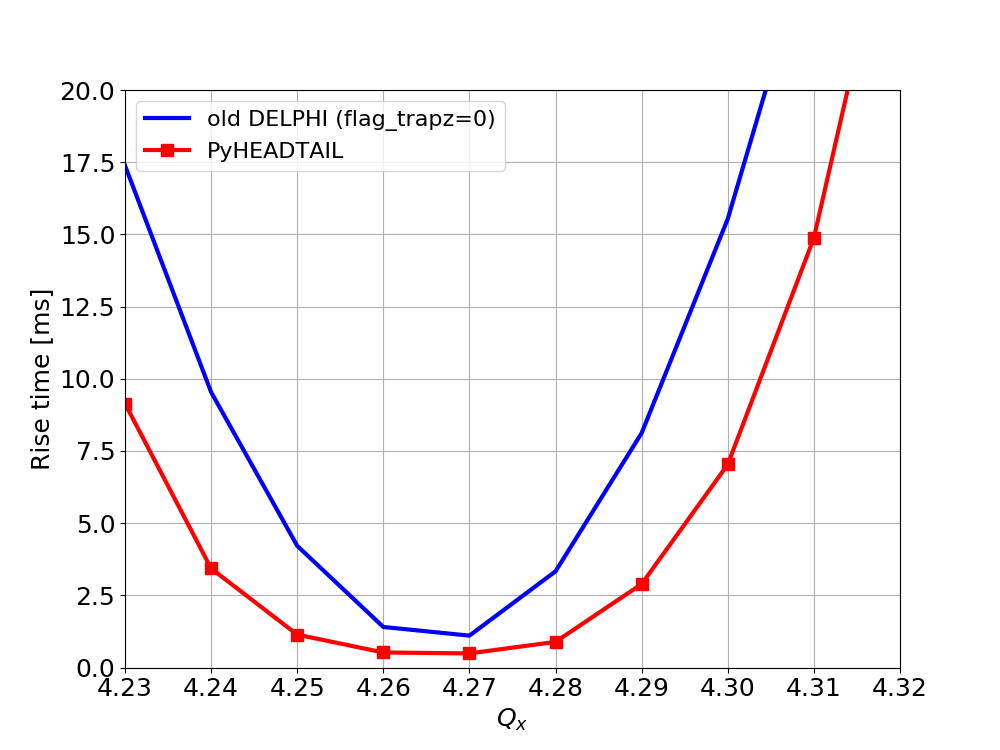

<IPython.core.display.Javascript object>


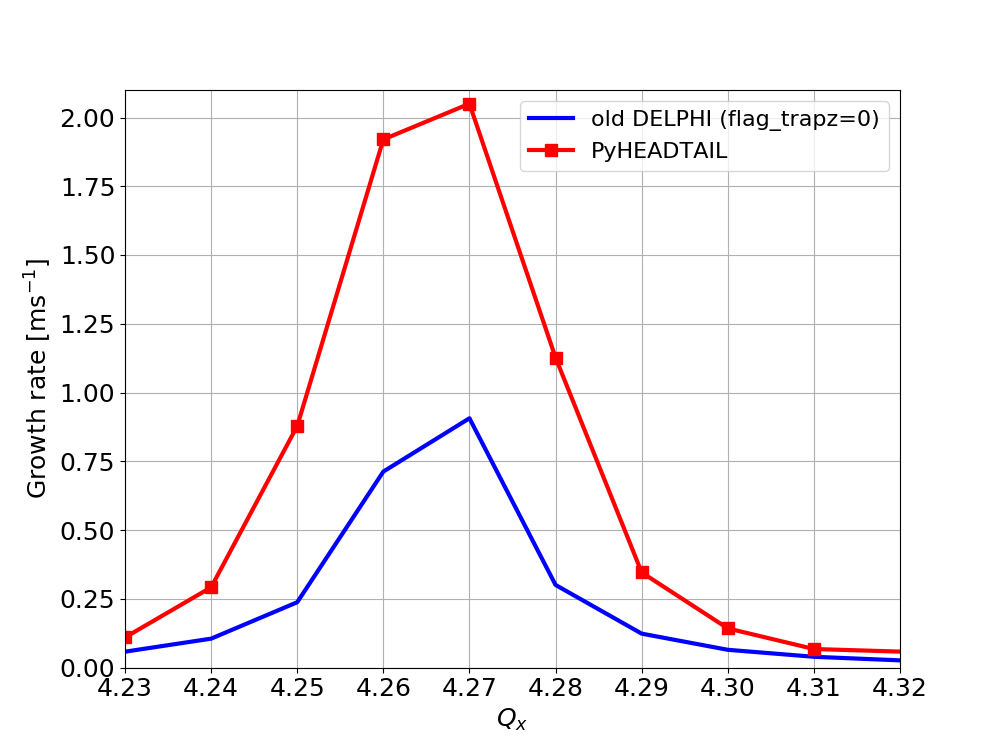

In [83]:
lab = 'old'

# PyHEADTAIL with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qx = [4.17,  4.18,  4.19,  4.2 ,  4.22,  4.23,  4.24,  4.25,  4.26,
        4.27,  4.28,  4.29,  4.3 ,  4.31,  4.36,  4.37,  4.41,  4.42,
        4.43,  4.44,  4.45,  4.46,  4.47,  4.48]
tau = [2.94816758e+02,  -2.73927555e+03,  -2.52865266e+02,
         4.54159568e+01,   2.65136856e+01,   9.14142010e+00,
         3.43054562e+00,   1.13875757e+00,   5.20761672e-01,
         4.87766411e-01,   8.87470409e-01,   2.89201778e+00,
         7.03217664e+00,   1.48787595e+01,  -1.42901661e+02,
         9.32281186e+01,  -6.23087358e+01,  -2.96131931e+02,
         1.00062446e+02,  -1.45910813e+02,  -1.72731598e+03,
        -6.47571274e+01,   6.23678388e+01,   5.59967966e+01]         
qx = np.array(qx)
tau = np.array(tau)

# DELPHI simulations with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qxD = [4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.30]
tauD = [11.45, 6.2, 2.65, 0.66, 0.61, 2.08, 5.13, 9.82]
qxD = np.array(qxD)
tauD = np.array(tauD)

dQ_imag  = np.array([np.imag(np.squeeze(dQ)[0]) for dQ in tuneshifts])
write_ncol_file(os.path.join(result_folder,'dQimag_PSB_HOM.txt'),
                np.hstack((Qxscan.reshape(-1,1),dQ_imag.reshape(-1,1))),header='Qx\tdQ_imag')

msk = (tau<0) | (tau>100)

# plot rise times
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e3/(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab))


plt.ylabel(r"Rise time [ms]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,20.])
plt.legend(fontsize=16)

# plot growth rates
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e-3*(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],1./tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab))


plt.ylabel(r"Growth rate [ms$^{{-1}}$]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,2.1])
plt.legend(fontsize=16)

## beta-compliant DELPHI calculation with flag_trapz=0 (scan in Qx)
It still fails miserably with flag_trapz=1

In [7]:
reload(sys.modules['DELPHI'])
from DELPHI import *

In [8]:
g, a, b = longdistribution_decomp(machine.taub, typelong='Gaussian')

print "Qy= {}, omega0={}, Qs= {}, gamma={}, eta={}, taub={}".format(machine.Qy,machine.omega0,machine.Qs,
                                                                    machine.gamma,machine._eta,machine.taub)

kmax = 1 # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot = 50; # number of kept and plotted eigenvalues (in TMCI plot)
# DELPHI convergence criteria
crit = 5e-2
abseps = 1e-4
flag_trapz = 0

# Chromaticity
#Qp = -3.5#-0.73*machine.Qx  # horizontal chroma
#omegaksi = Qp*machine.omega0 / machine._eta

# Number of bunches
M = 1
# Damper gain and phase
damp = 0.0
dphase = 0
# Intensity scan
#Nbscan = np.arange(0, 5.2e11, 2e10)
Nbscan = [4e12]
Qxscan = np.arange(4.17, 4.49, 0.01)# 4.10, 4.45, 0.01)
Qxscan = np.arange(4.23, 4.35, 0.01)# 4.10, 4.45, 0.01)

tuneshifts = []
#eigenvectors = []

scenario = 'Eirini_old_DELPHI_beta_compliant'
result_folder = os.path.join(ResultDir,scenario)
os.system("mkdir -p "+result_folder)

DELPHI_params = {'Mscan': [M],
                 'Qxscan': Qxscan.tolist(),
                 'Qpscan': (-0.73*Qxscan).tolist(),
                 'dampscan': [damp],
                 'Nbscan': Nbscan,
                 'omegasscan': [machine.omegas],
                 'dphasescan': [dphase],
                 'omega0': machine.omega0,
                 'Qy': machine.Qy,
                 'gamma': machine.gamma, 'eta': machine._eta,
                 'a': a,'b': b,
                 'taub': machine.taub, 'g': g.tolist(),
                 'planes': ['x'],
                 'nevery': nevery,
                 'particle': 'proton',
                 'flagnorm': flagnorm,'flagdamperimp': flagdamperimp,
                 'd': d, 'freqd': freqd,
                 'kmax': kmax, 'kmaxplot': kmaxplot,
                 'crit': crit, 'abseps': abseps, 
                 'flagm0': flagm0, 'flageigenvect': flageigenvect,
                 'flag_trapz': flag_trapz,
                 'lxplusbatch': None,
                 'comment': "{}_{}".format(machine_name,scenario),
                 'queue': '2nd', 'dire': result_folder+'/',
                 'flagQpscan_outside': True,
                 }

with open(os.path.join(result_folder,'DELPHI_parameters.json'), 'w') as f:
    f.write(json.dumps(DELPHI_params,indent=4))


print (machine.taub / 4) * machine.beta * clight
t0 = ti.clock()
for Qx in Qxscan:
    
    print "="*60
    Qp = -0.73*Qx
    #Qp = -3.5 # the value needed to get back (some of) Eirini's DELPHI results
    dQ, _ = DELPHI_wrapper(imp_mod, [M], [Qp], [damp], Nbscan, [machine.omegas], [dphase], machine.omega0,
                           Qx, machine.Qy, machine.gamma, machine._eta, a, b, machine.taub, g, ['x'],
                           nevery=nevery, particle='proton', flagnorm=flagnorm, flagdamperimp=flagdamperimp,
                           d=d, freqd=freqd, kmax=kmax, kmaxplot=kmaxplot, flag_trapz=0,
                           crit=crit, abseps=abseps, flagm0=flagm0, flageigenvect=flageigenvect,
                           lxplusbatch=None, comment="{}_{}_{}".format(machine_name,scenario,float_to_str(Qx)),
                           queue='2nd', dire=result_folder+'/', flagQpscan_outside=True)
    
    print "Qx={}, Qpx={}: most unstable mode dQ={}".format(Qx,Qp,np.squeeze(dQ)[0])
    tuneshifts.append(dQ)
    #eigenvectors.append(v)

t1 = ti.clock()
print("Elapsed time: {} s".format(t1-t0))
# output is not the right one (some bady copy-paste happened)

Qy= 4.2, omega0=6233102.82351, Qs= 0.0016953, gamma=1.17052622918, eta=-0.669696870079, taub=4.8e-07
18.6981617627037


UnboundLocalError: local variable 'eigenval' referenced before assignment

### Plot rise times vs Qx, and comparison with PyHEADTAIL

<IPython.core.display.Javascript object>


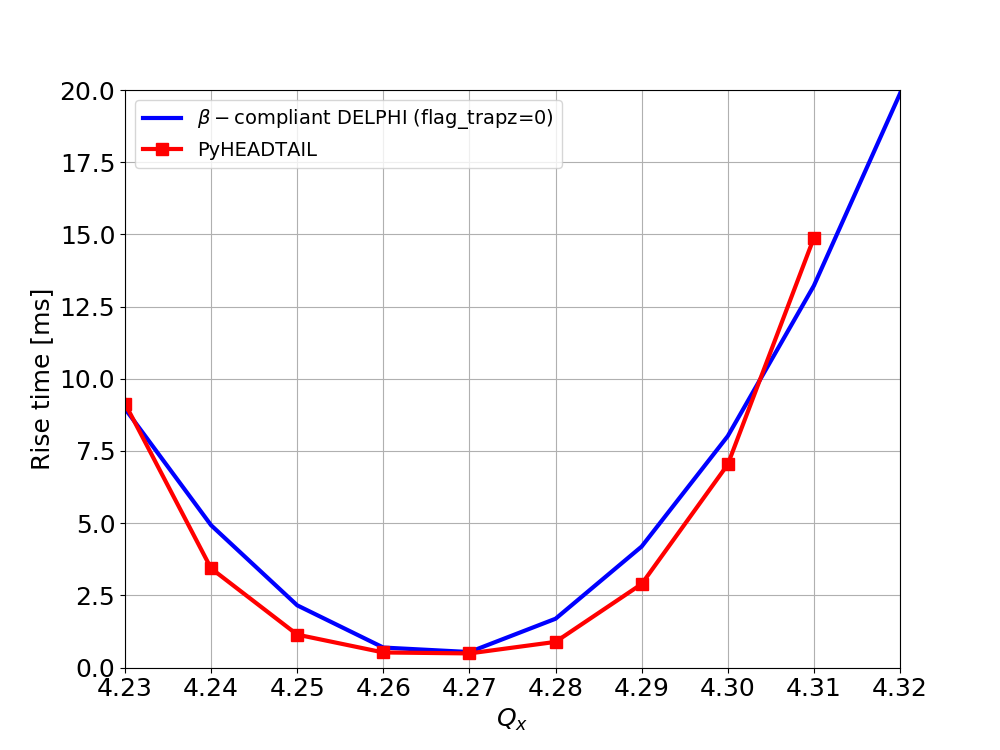

<IPython.core.display.Javascript object>


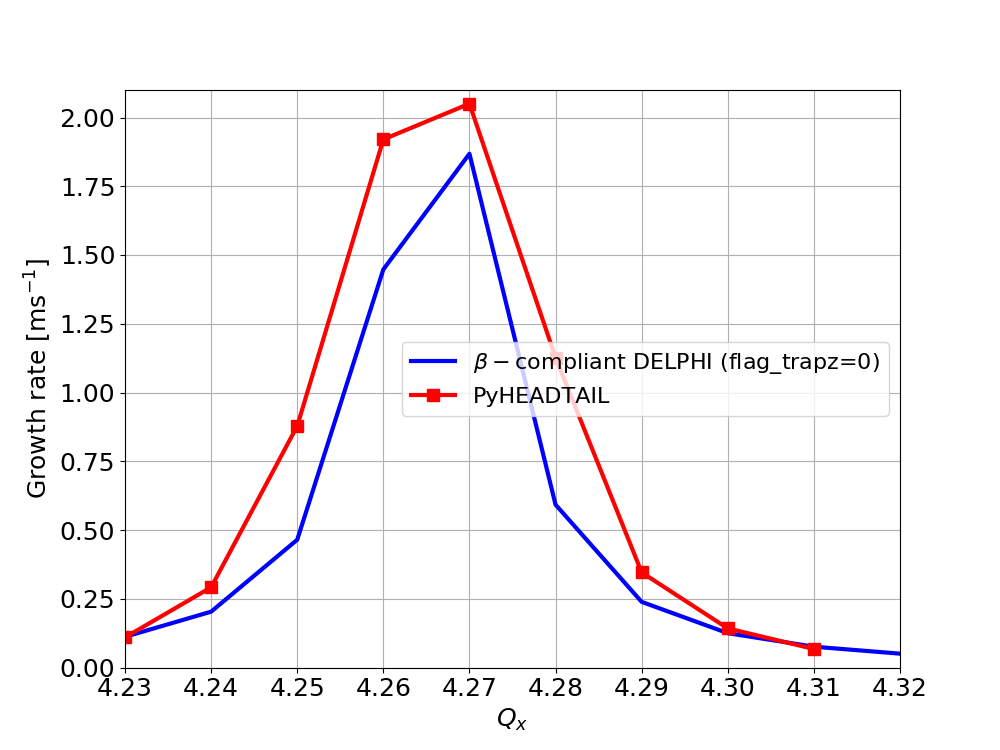

In [86]:
lab = r"$\beta -$compliant"

# PyHEADTAIL with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qx = [4.17,  4.18,  4.19,  4.2 ,  4.22,  4.23,  4.24,  4.25,  4.26,
        4.27,  4.28,  4.29,  4.3 ,  4.31,  4.36,  4.37,  4.41,  4.42,
        4.43,  4.44,  4.45,  4.46,  4.47,  4.48]
tau = [2.94816758e+02,  -2.73927555e+03,  -2.52865266e+02,
         4.54159568e+01,   2.65136856e+01,   9.14142010e+00,
         3.43054562e+00,   1.13875757e+00,   5.20761672e-01,
         4.87766411e-01,   8.87470409e-01,   2.89201778e+00,
         7.03217664e+00,   1.48787595e+01,  -1.42901661e+02,
         9.32281186e+01,  -6.23087358e+01,  -2.96131931e+02,
         1.00062446e+02,  -1.45910813e+02,  -1.72731598e+03,
        -6.47571274e+01,   6.23678388e+01,   5.59967966e+01]         
qx = np.array(qx)
tau = np.array(tau)

# DELPHI simulations with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qxD = [4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.30]
tauD = [11.45, 6.2, 2.65, 0.66, 0.61, 2.08, 5.13, 9.82]
qxD = np.array(qxD)
tauD = np.array(tauD)

dQ_imag  = np.array([np.imag(np.squeeze(dQ)[0]) for dQ in tuneshifts])
write_ncol_file(os.path.join(result_folder,'dQimag_PSB_HOM.txt'),
                np.hstack((Qxscan.reshape(-1,1),dQ_imag.reshape(-1,1))),header='Qx\tdQ_imag')
    
msk = (tau<0) | (tau>50)

# plot rise times
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e3/(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab)) 
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Rise time [ms]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,20.])
plt.legend(fontsize=14)

# plot growth rates
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e-3*(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],1./tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,1./tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab))
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Growth rate [ms$^{{-1}}$]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,2.1])
plt.legend(fontsize=16)

## beta-compliant, factorial corrected DELPHI calculation with flag_trapz=0 (scan in Qx)
It still fails miserably with flag_trapz=1 (nan or inf in matrix)

In [10]:
reload(sys.modules['DELPHI'])
from DELPHI import *

In [11]:
g, a, b = longdistribution_decomp(machine.taub, typelong='Gaussian')

print "Qy= {}, omega0={}, Qs= {}, gamma={}, eta={}, taub={}".format(machine.Qy,machine.omega0,machine.Qs,
                                                                    machine.gamma,machine._eta,machine.taub)

kmax = 1 # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot = 50; # number of kept and plotted eigenvalues (in TMCI plot)
# DELPHI convergence criteria
crit = 5e-2
abseps = 1e-4
flag_trapz = 0

# Chromaticity
#Qp = -3.5#-0.73*machine.Qx  # horizontal chroma
#omegaksi = Qp*machine.omega0 / machine._eta

# Number of bunches
M = 1
# Damper gain and phase
damp = 0.0
dphase = 0
# Intensity scan
#Nbscan = np.arange(0, 5.2e11, 2e10)
Nbscan = [4e12]
Qxscan = np.arange(4.17, 4.49, 0.01)# 4.10, 4.45, 0.01)
Qxscan = np.arange(4.23, 4.35, 0.01)# 4.10, 4.45, 0.01)

tuneshifts = []
#eigenvectors = []

scenario = 'Eirini_fact_cor_DELPHI_beta_compliant'
result_folder = os.path.join(ResultDir,scenario)
os.system("mkdir -p "+result_folder)

DELPHI_params = {'Mscan': [M],
                 'Qxscan': Qxscan.tolist(),
                 'Qpscan': (-0.73*Qxscan).tolist(),
                 'dampscan': [damp],
                 'Nbscan': Nbscan,
                 'omegasscan': [machine.omegas],
                 'dphasescan': [dphase],
                 'omega0': machine.omega0,
                 'Qy': machine.Qy,
                 'gamma': machine.gamma, 'eta': machine._eta,
                 'a': a,'b': b,
                 'taub': machine.taub, 'g': g.tolist(),
                 'planes': ['x'],
                 'nevery': nevery,
                 'particle': 'proton',
                 'flagnorm': flagnorm,'flagdamperimp': flagdamperimp,
                 'd': d, 'freqd': freqd,
                 'kmax': kmax, 'kmaxplot': kmaxplot,
                 'crit': crit, 'abseps': abseps, 
                 'flagm0': flagm0, 'flageigenvect': flageigenvect,
                 'flag_trapz': flag_trapz,
                 'lxplusbatch': None,
                 'comment': "{}_{}".format(machine_name,scenario),
                 'queue': '2nd', 'dire': result_folder+'/',
                 'flagQpscan_outside': True,
                 }

with open(os.path.join(result_folder,'DELPHI_parameters.json'), 'w') as f:
    f.write(json.dumps(DELPHI_params,indent=4))


print (machine.taub / 4) * machine.beta * clight
t0 = ti.clock()
for Qx in Qxscan:
    
    print "="*60
    Qp = -0.73*Qx
    #Qp = -3.5 # the value needed to get back (some of) Eirini's DELPHI results
    dQ, _ = DELPHI_wrapper(imp_mod, [M], [Qp], [damp], Nbscan, [machine.omegas], [dphase], machine.omega0,
                           Qx, machine.Qy, machine.gamma, machine._eta, a, b, machine.taub, g, ['x'],
                           nevery=nevery, particle='proton', flagnorm=flagnorm, flagdamperimp=flagdamperimp,
                           d=d, freqd=freqd, kmax=kmax, kmaxplot=kmaxplot, flag_trapz=0,
                           crit=crit, abseps=abseps, flagm0=flagm0, flageigenvect=flageigenvect,
                           lxplusbatch=None, comment="{}_{}_{}".format(machine_name,scenario,float_to_str(Qx)),
                           queue='2nd', dire=result_folder+'/', flagQpscan_outside=True)
    
    print "Qx={}, Qpx={}: most unstable mode dQ={}".format(Qx,Qp,np.squeeze(dQ)[0])
    tuneshifts.append(dQ)
    #eigenvectors.append(v)

t1 = ti.clock()
print("Elapsed time: {} s".format(t1-t0))

Qy= 4.2, omega0=6233102.82351, Qs= 0.0016953, gamma=1.17052622918, eta=-0.669696870079, taub=4.8e-07
18.6981617627037
Qp= -3.0879000000000003 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.23, Qpx=-3.0879: most unstable mode dQ=(0.0017662941118-1.78951578085e-05j)
Qp= -3.0952 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.24, Qpx=-3.0952: most unstable mode dQ=(0.00178975904224-3.256700359e-05j)
Qp= -3.1025 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.25, Qpx=-3.1025: most unstable mode dQ=(0.00351994269129-7.45287855531e-05j)
Qp= -3.1098 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.26, Qpx=-3

### Plot rise times vs Qx, and comparison with PyHEADTAIL

<IPython.core.display.Javascript object>


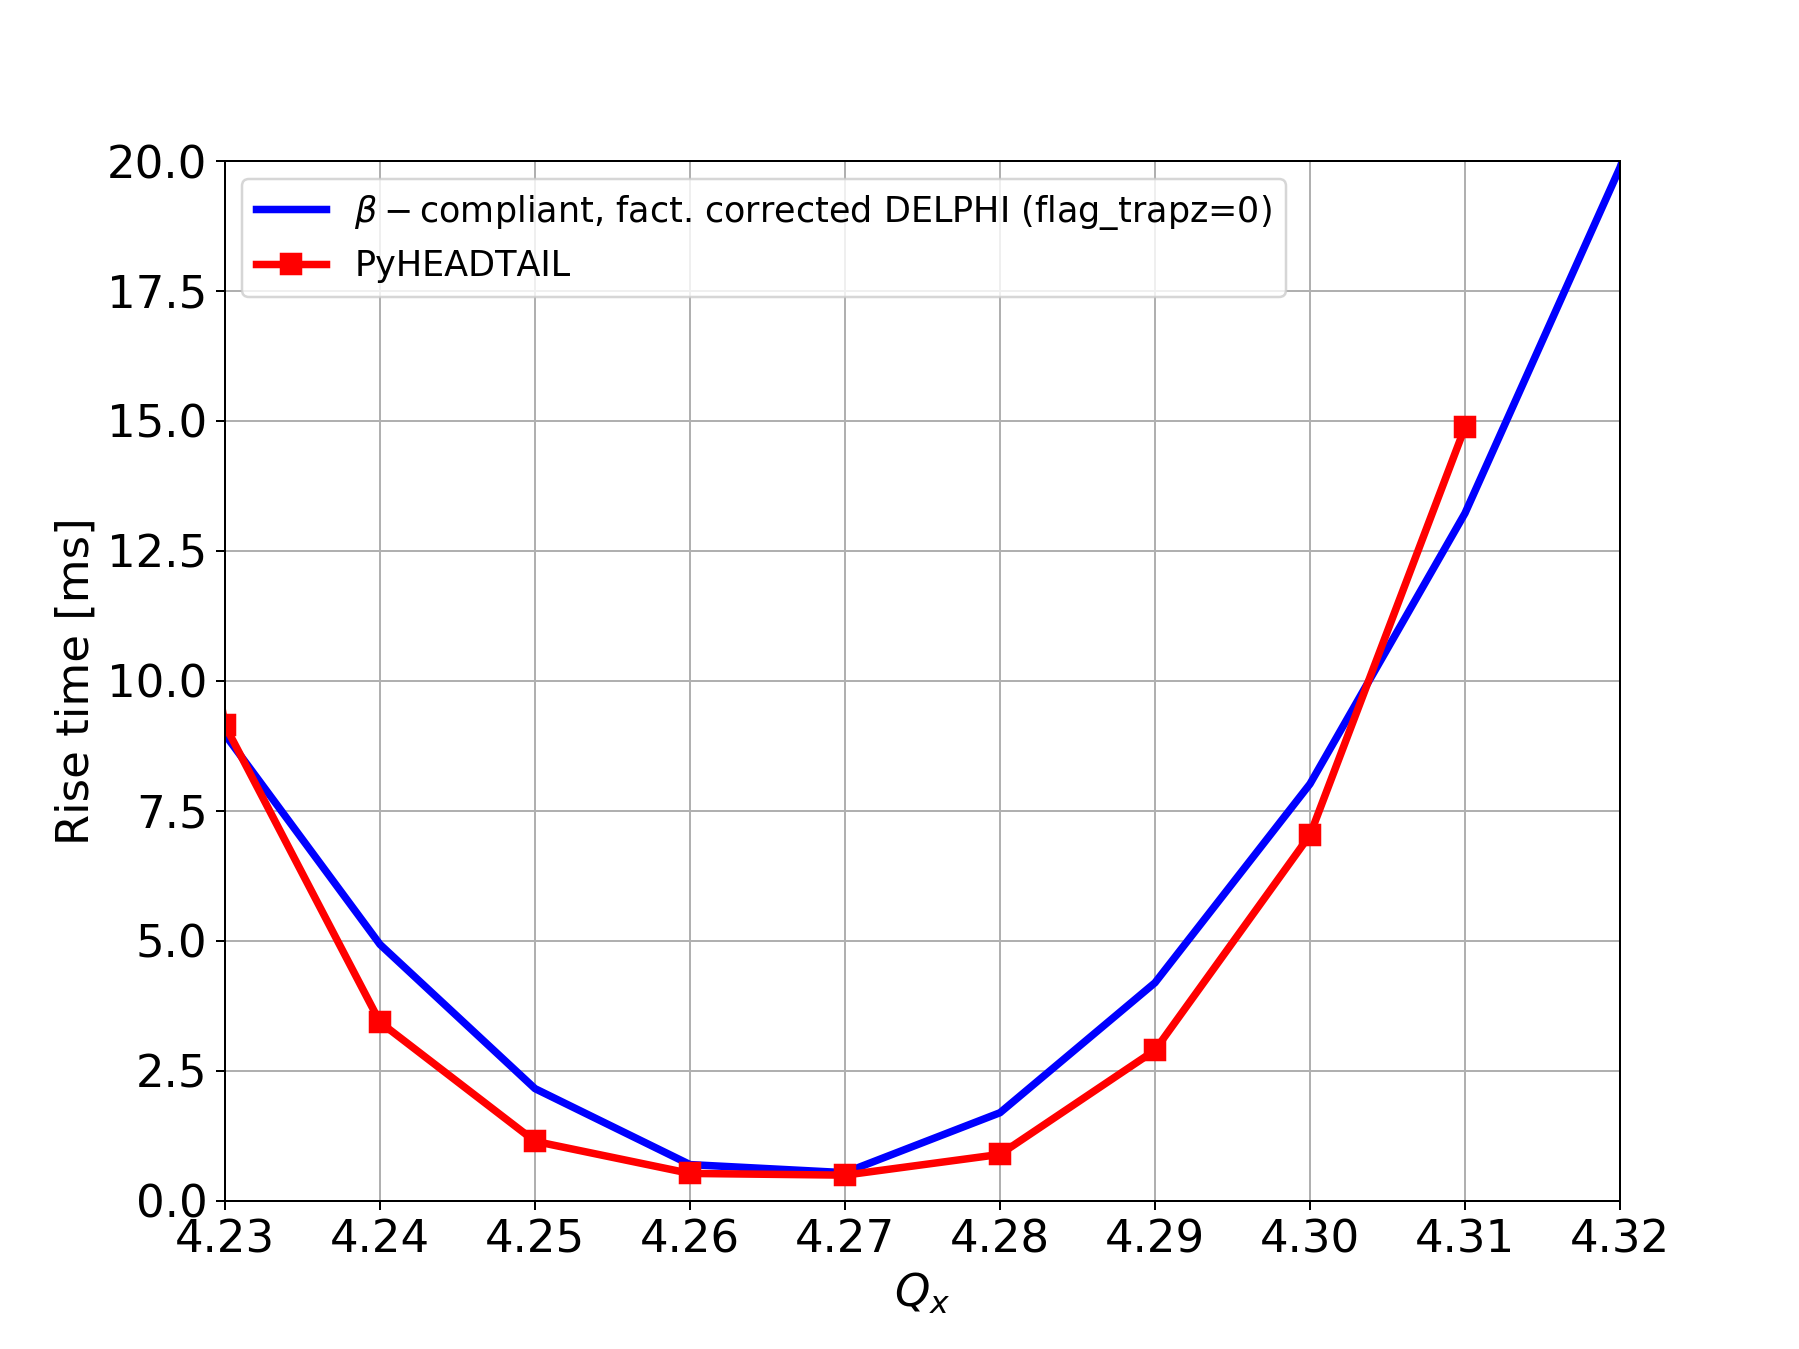

<IPython.core.display.Javascript object>


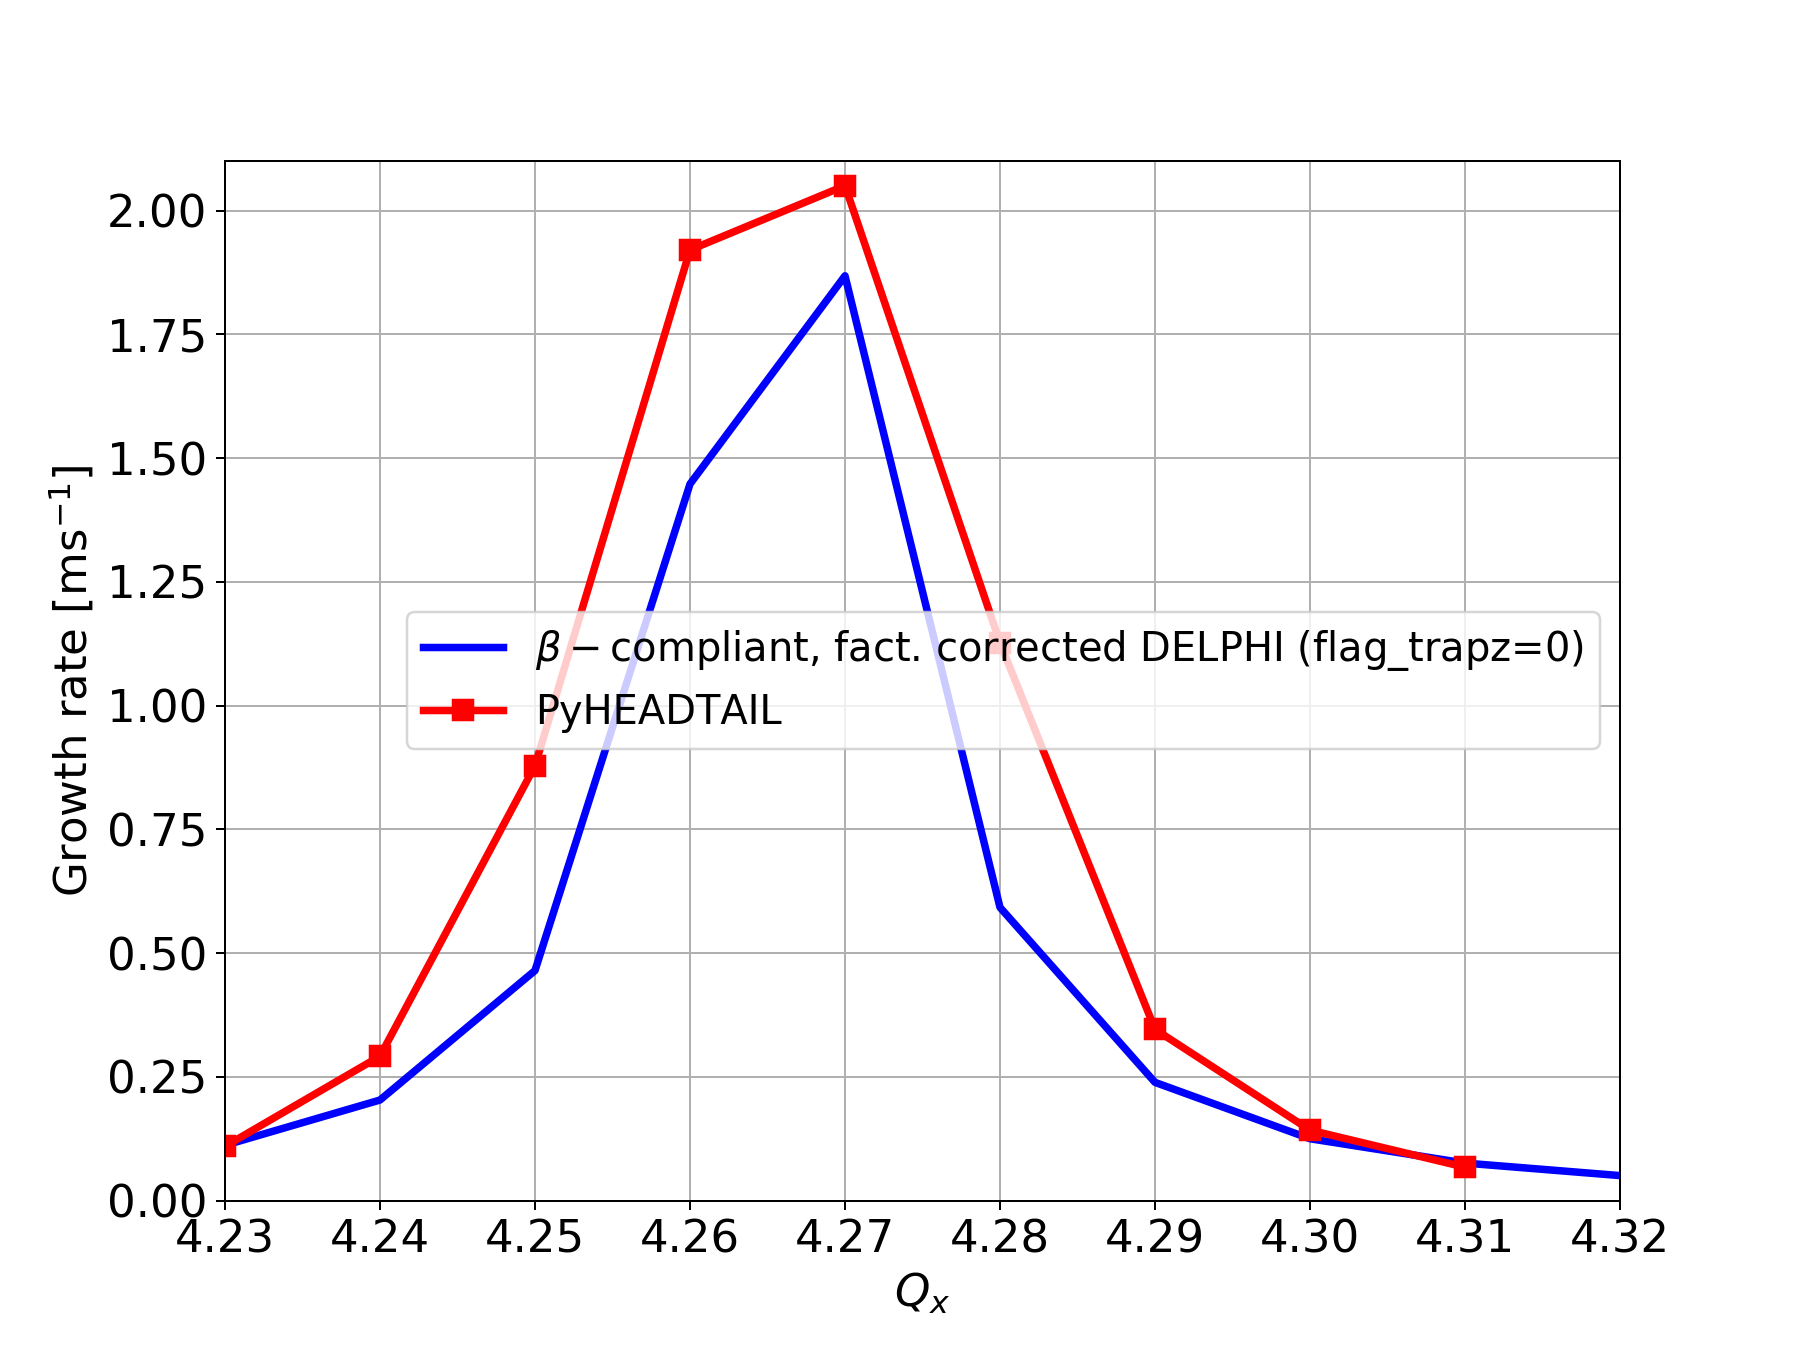

In [12]:
lab = r"$\beta -$compliant, fact. corrected"

# PyHEADTAIL with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qx = [4.17,  4.18,  4.19,  4.2 ,  4.22,  4.23,  4.24,  4.25,  4.26,
        4.27,  4.28,  4.29,  4.3 ,  4.31,  4.36,  4.37,  4.41,  4.42,
        4.43,  4.44,  4.45,  4.46,  4.47,  4.48]
tau = [2.94816758e+02,  -2.73927555e+03,  -2.52865266e+02,
         4.54159568e+01,   2.65136856e+01,   9.14142010e+00,
         3.43054562e+00,   1.13875757e+00,   5.20761672e-01,
         4.87766411e-01,   8.87470409e-01,   2.89201778e+00,
         7.03217664e+00,   1.48787595e+01,  -1.42901661e+02,
         9.32281186e+01,  -6.23087358e+01,  -2.96131931e+02,
         1.00062446e+02,  -1.45910813e+02,  -1.72731598e+03,
        -6.47571274e+01,   6.23678388e+01,   5.59967966e+01]         
qx = np.array(qx)
tau = np.array(tau)

# DELPHI simulations with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qxD = [4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.30]
tauD = [11.45, 6.2, 2.65, 0.66, 0.61, 2.08, 5.13, 9.82]
qxD = np.array(qxD)
tauD = np.array(tauD)

dQ_imag  = np.array([np.imag(np.squeeze(dQ)[0]) for dQ in tuneshifts])
write_ncol_file(os.path.join(result_folder,'dQimag_PSB_HOM.txt'),
                np.hstack((Qxscan.reshape(-1,1),dQ_imag.reshape(-1,1))),header='Qx\tdQ_imag')
    
msk = (tau<0) | (tau>50)

# plot rise times
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e3/(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab)) 
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Rise time [ms]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,20.])
plt.legend(fontsize=14)

# plot growth rates
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e-3*(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],1./tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,1./tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab))
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Growth rate [ms$^{{-1}}$]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,2.1])
plt.legend(fontsize=16)

## beta-compliant, impedance sum corrected DELPHI calculation with flag_trapz=0 (scan in Qx)
It still fails miserably with flag_trapz=1 (nan or inf in matrix)

In [6]:
reload(sys.modules['DELPHI'])
from DELPHI import *

In [8]:
g, a, b = longdistribution_decomp(machine.taub, typelong='Gaussian')

print "Qy= {}, omega0={}, Qs= {}, gamma={}, eta={}, taub={}".format(machine.Qy,machine.omega0,machine.Qs,
                                                                    machine.gamma,machine._eta,machine.taub)

kmax = 1 # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot = 50; # number of kept and plotted eigenvalues (in TMCI plot)
# DELPHI convergence criteria
crit = 5e-2
abseps = 1e-4
flag_trapz = 0

# Chromaticity
#Qp = -3.5#-0.73*machine.Qx  # horizontal chroma
#omegaksi = Qp*machine.omega0 / machine._eta

# Number of bunches
M = 1
# Damper gain and phase
damp = 0.0
dphase = 0
# Intensity scan
#Nbscan = np.arange(0, 5.2e11, 2e10)
Nbscan = [4e12]
Qxscan = np.arange(4.17, 4.49, 0.01)# 4.10, 4.45, 0.01)
Qxscan = np.arange(4.23, 4.35, 0.01)# 4.10, 4.45, 0.01)

tuneshifts = []
#eigenvectors = []

scenario = 'Eirini_isum_cor_DELPHI_beta_compliant'
result_folder = os.path.join(ResultDir,scenario)
os.system("mkdir -p "+result_folder)

DELPHI_params = {'Mscan': [M],
                 'Qxscan': Qxscan.tolist(),
                 'Qpscan': (-0.73*Qxscan).tolist(),
                 'dampscan': [damp],
                 'Nbscan': Nbscan,
                 'omegasscan': [machine.omegas],
                 'dphasescan': [dphase],
                 'omega0': machine.omega0,
                 'Qy': machine.Qy,
                 'gamma': machine.gamma, 'eta': machine._eta,
                 'a': a,'b': b,
                 'taub': machine.taub, 'g': g.tolist(),
                 'planes': ['x'],
                 'nevery': nevery,
                 'particle': 'proton',
                 'flagnorm': flagnorm,'flagdamperimp': flagdamperimp,
                 'd': d, 'freqd': freqd,
                 'kmax': kmax, 'kmaxplot': kmaxplot,
                 'crit': crit, 'abseps': abseps, 
                 'flagm0': flagm0, 'flageigenvect': flageigenvect,
                 'flag_trapz': flag_trapz,
                 'lxplusbatch': None,
                 'comment': "{}_{}".format(machine_name,scenario),
                 'queue': '2nd', 'dire': result_folder+'/',
                 'flagQpscan_outside': True,
                 }

with open(os.path.join(result_folder,'DELPHI_parameters.json'), 'w') as f:
    f.write(json.dumps(DELPHI_params,indent=4))


print (machine.taub / 4) * machine.beta * clight
t0 = ti.clock()
for Qx in Qxscan:
    
    print "="*60
    Qp = -0.73*Qx
    #Qp = -3.5 # the value needed to get back (some of) Eirini's DELPHI results
    dQ, _ = DELPHI_wrapper(imp_mod, [M], [Qp], [damp], Nbscan, [machine.omegas], [dphase], machine.omega0,
                           Qx, machine.Qy, machine.gamma, machine._eta, a, b, machine.taub, g, ['x'],
                           nevery=nevery, particle='proton', flagnorm=flagnorm, flagdamperimp=flagdamperimp,
                           d=d, freqd=freqd, kmax=kmax, kmaxplot=kmaxplot, flag_trapz=0,
                           crit=crit, abseps=abseps, flagm0=flagm0, flageigenvect=flageigenvect,
                           lxplusbatch=None, comment="{}_{}_{}".format(machine_name,scenario,float_to_str(Qx)),
                           queue='2nd', dire=result_folder+'/', flagQpscan_outside=True)
    
    print "Qx={}, Qpx={}: most unstable mode dQ={}".format(Qx,Qp,np.squeeze(dQ)[0])
    tuneshifts.append(dQ)
    #eigenvectors.append(v)

t1 = ti.clock()
print("Elapsed time: {} s".format(t1-t0))

Qy= 4.2, omega0=6233102.82351, Qs= 0.0016953, gamma=1.17052622918, eta=-0.669696870079, taub=4.8e-07
18.6981617627037
Qp= -3.0879000000000003 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.23, Qpx=-3.0879: most unstable mode dQ=(0.0017662941118-1.78951578085e-05j)
Qp= -3.0952 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.24, Qpx=-3.0952: most unstable mode dQ=(0.00178975904224-3.256700359e-05j)
Qp= -3.1025 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.25, Qpx=-3.1025: most unstable mode dQ=(0.00351994269129-7.45287855531e-05j)
Qp= -3.1098 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.26, Qpx=-3

### Plot rise times vs Qx, and comparison with PyHEADTAIL

<IPython.core.display.Javascript object>


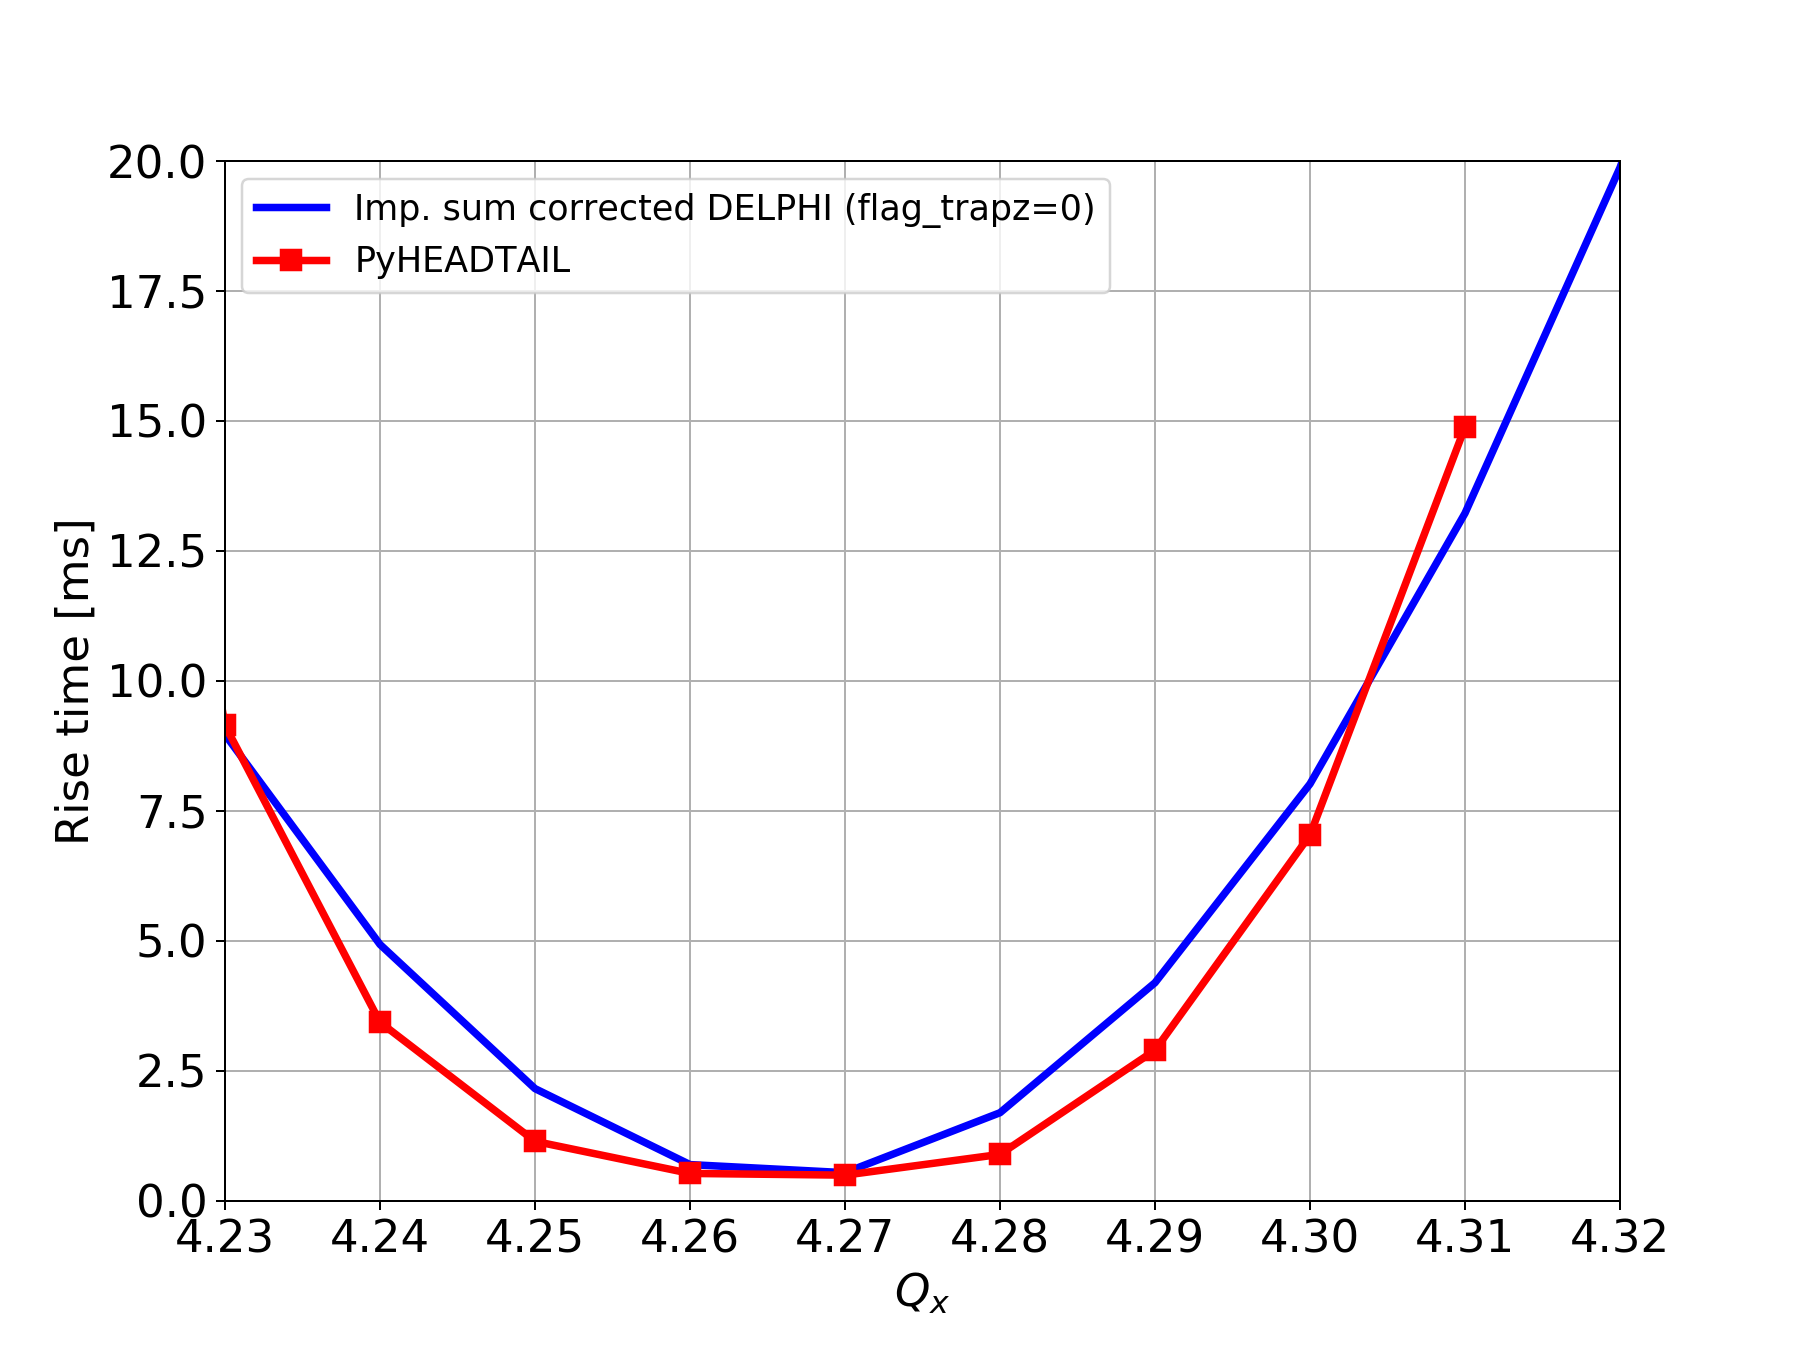

<IPython.core.display.Javascript object>


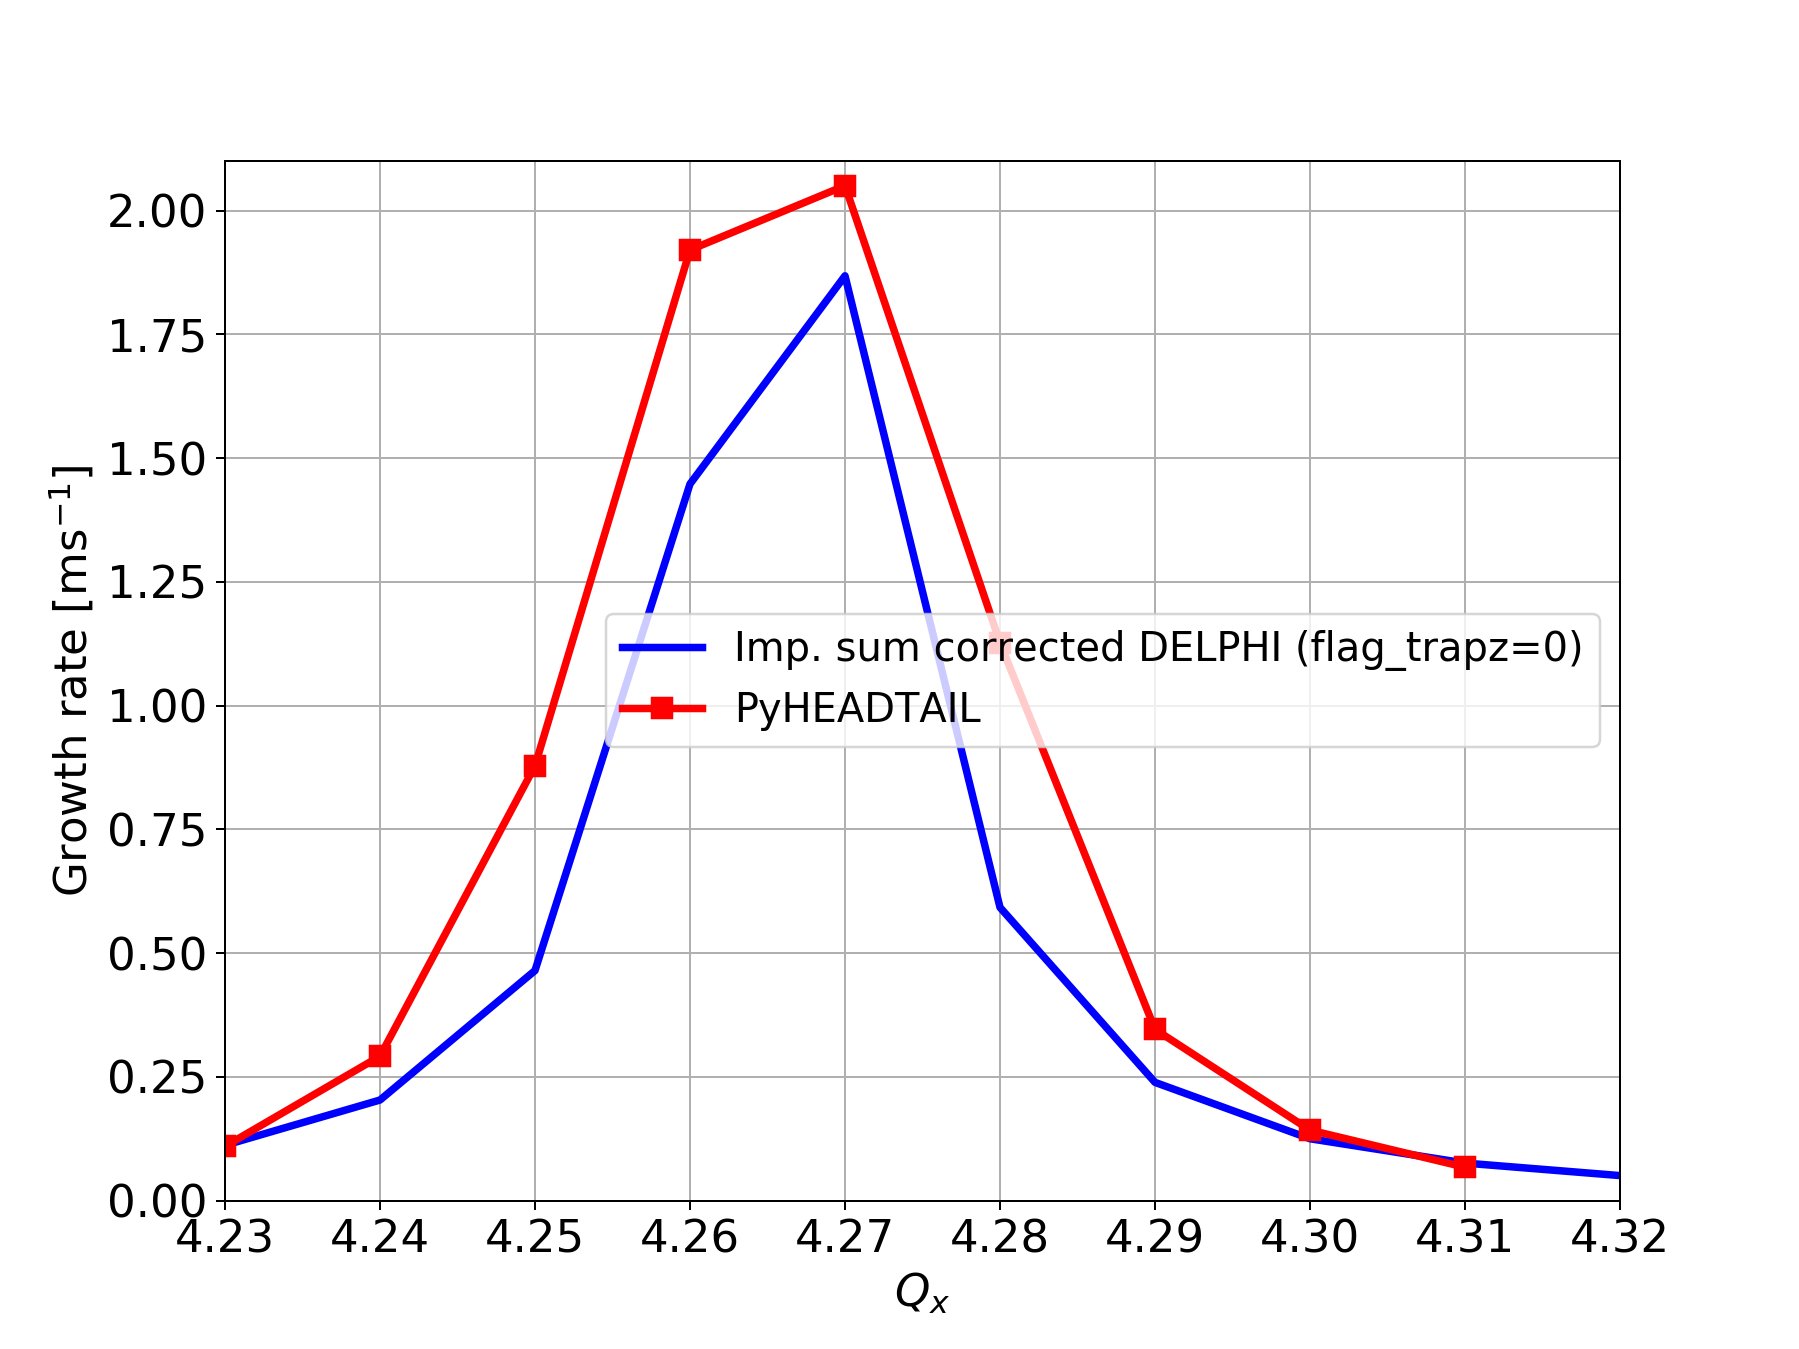

In [9]:
lab = r"Imp. sum corrected"

# PyHEADTAIL with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qx = [4.17,  4.18,  4.19,  4.2 ,  4.22,  4.23,  4.24,  4.25,  4.26,
        4.27,  4.28,  4.29,  4.3 ,  4.31,  4.36,  4.37,  4.41,  4.42,
        4.43,  4.44,  4.45,  4.46,  4.47,  4.48]
tau = [2.94816758e+02,  -2.73927555e+03,  -2.52865266e+02,
         4.54159568e+01,   2.65136856e+01,   9.14142010e+00,
         3.43054562e+00,   1.13875757e+00,   5.20761672e-01,
         4.87766411e-01,   8.87470409e-01,   2.89201778e+00,
         7.03217664e+00,   1.48787595e+01,  -1.42901661e+02,
         9.32281186e+01,  -6.23087358e+01,  -2.96131931e+02,
         1.00062446e+02,  -1.45910813e+02,  -1.72731598e+03,
        -6.47571274e+01,   6.23678388e+01,   5.59967966e+01]         
qx = np.array(qx)
tau = np.array(tau)

# DELPHI simulations with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qxD = [4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.30]
tauD = [11.45, 6.2, 2.65, 0.66, 0.61, 2.08, 5.13, 9.82]
qxD = np.array(qxD)
tauD = np.array(tauD)

dQ_imag  = np.array([np.imag(np.squeeze(dQ)[0]) for dQ in tuneshifts])
write_ncol_file(os.path.join(result_folder,'dQimag_PSB_HOM.txt'),
                np.hstack((Qxscan.reshape(-1,1),dQ_imag.reshape(-1,1))),header='Qx\tdQ_imag')
    
msk = (tau<0) | (tau>50)

# plot rise times
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e3/(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab)) 
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Rise time [ms]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,20.])
plt.legend(fontsize=14)

# plot growth rates
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e-3*(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],1./tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,1./tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab))
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Growth rate [ms$^{{-1}}$]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,2.1])
plt.legend(fontsize=16)

## Extended matrix DELPHI calculation with flag_trapz=0 (scan in Qx)
It still fails miserably with flag_trapz=1 (nan or inf in matrix)

In [15]:
reload(sys.modules['DELPHI'])
from DELPHI import *

In [18]:
g, a, b = longdistribution_decomp(machine.taub, typelong='Gaussian')

print "Qy= {}, omega0={}, Qs= {}, gamma={}, eta={}, taub={}".format(machine.Qy,machine.omega0,machine.Qs,
                                                                    machine.gamma,machine._eta,machine.taub)

kmax = 1 # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot = 50; # number of kept and plotted eigenvalues (in TMCI plot)
# DELPHI convergence criteria
crit = 5e-2
abseps = 1e-4
flag_trapz = 0

# Chromaticity
#Qp = -3.5#-0.73*machine.Qx  # horizontal chroma
#omegaksi = Qp*machine.omega0 / machine._eta

# Number of bunches
M = 1
# Damper gain and phase
damp = 0.0
dphase = 0
# Intensity scan
#Nbscan = np.arange(0, 5.2e11, 2e10)
Nbscan = [4e12]
Qxscan = np.arange(4.17, 4.49, 0.01)# 4.10, 4.45, 0.01)
Qxscan = np.arange(4.23, 4.35, 0.01)# 4.10, 4.45, 0.01)

tuneshifts = []
#eigenvectors = []

scenario = 'Eirini_ext_mat_DELPHI_beta_compliant'
result_folder = os.path.join(ResultDir,scenario)
os.system("mkdir -p "+result_folder)

DELPHI_params = {'Mscan': [M],
                 'Qxscan': Qxscan.tolist(),
                 'Qpscan': (-0.73*Qxscan).tolist(),
                 'dampscan': [damp],
                 'Nbscan': Nbscan,
                 'omegasscan': [machine.omegas],
                 'dphasescan': [dphase],
                 'omega0': machine.omega0,
                 'Qy': machine.Qy,
                 'gamma': machine.gamma, 'eta': machine._eta,
                 'a': a,'b': b,
                 'taub': machine.taub, 'g': g.tolist(),
                 'planes': ['x'],
                 'nevery': nevery,
                 'particle': 'proton',
                 'flagnorm': flagnorm,'flagdamperimp': flagdamperimp,
                 'd': d, 'freqd': freqd,
                 'kmax': kmax, 'kmaxplot': kmaxplot,
                 'crit': crit, 'abseps': abseps, 
                 'flagm0': flagm0, 'flageigenvect': flageigenvect,
                 'flag_trapz': flag_trapz,
                 'lxplusbatch': None,
                 'comment': "{}_{}".format(machine_name,scenario),
                 'queue': '2nd', 'dire': result_folder+'/',
                 'flagQpscan_outside': True,
                 }

with open(os.path.join(result_folder,'DELPHI_parameters.json'), 'w') as f:
    f.write(json.dumps(DELPHI_params,indent=4))


print (machine.taub / 4) * machine.beta * clight
t0 = ti.clock()
for Qx in Qxscan:
    
    print "="*60
    Qp = -0.73*Qx
    #Qp = -3.5 # the value needed to get back (some of) Eirini's DELPHI results
    dQ, _ = DELPHI_wrapper(imp_mod, [M], [Qp], [damp], Nbscan, [machine.omegas], [dphase], machine.omega0,
                           Qx, machine.Qy, machine.gamma, machine._eta, a, b, machine.taub, g, ['x'],
                           nevery=nevery, particle='proton', flagnorm=flagnorm, flagdamperimp=flagdamperimp,
                           d=d, freqd=freqd, kmax=kmax, kmaxplot=kmaxplot, flag_trapz=flag_trapz,
                           crit=crit, abseps=abseps, flagm0=flagm0, flageigenvect=flageigenvect,
                           lxplusbatch=None, comment="{}_{}_{}".format(machine_name,scenario,float_to_str(Qx)),
                           queue='2nd', dire=result_folder+'/', flagQpscan_outside=True)
    
    print "Qx={}, Qpx={}: most unstable mode dQ={}".format(Qx,Qp,np.squeeze(dQ)[0])
    tuneshifts.append(dQ)
    #eigenvectors.append(v)

t1 = ti.clock()
print("Elapsed time: {} s".format(t1-t0))

Qy= 4.2, omega0=6233102.82351, Qs= 0.0016953, gamma=1.17052622918, eta=-0.669696870079, taub=4.8e-07
18.6981617627037
Qp= -3.0879000000000003 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.23, Qpx=-3.0879: most unstable mode dQ=(0.0017662941118-1.78951578085e-05j)
Qp= -3.0952 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.24, Qpx=-3.0952: most unstable mode dQ=(0.00178975904224-3.256700359e-05j)
Qp= -3.1025 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.25, Qpx=-3.1025: most unstable mode dQ=(0.00351994269129-7.45287855531e-05j)
Qp= -3.1098 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 15 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.26, Qpx=-3

### Plot rise times vs Qx, and comparison with PyHEADTAIL

<IPython.core.display.Javascript object>


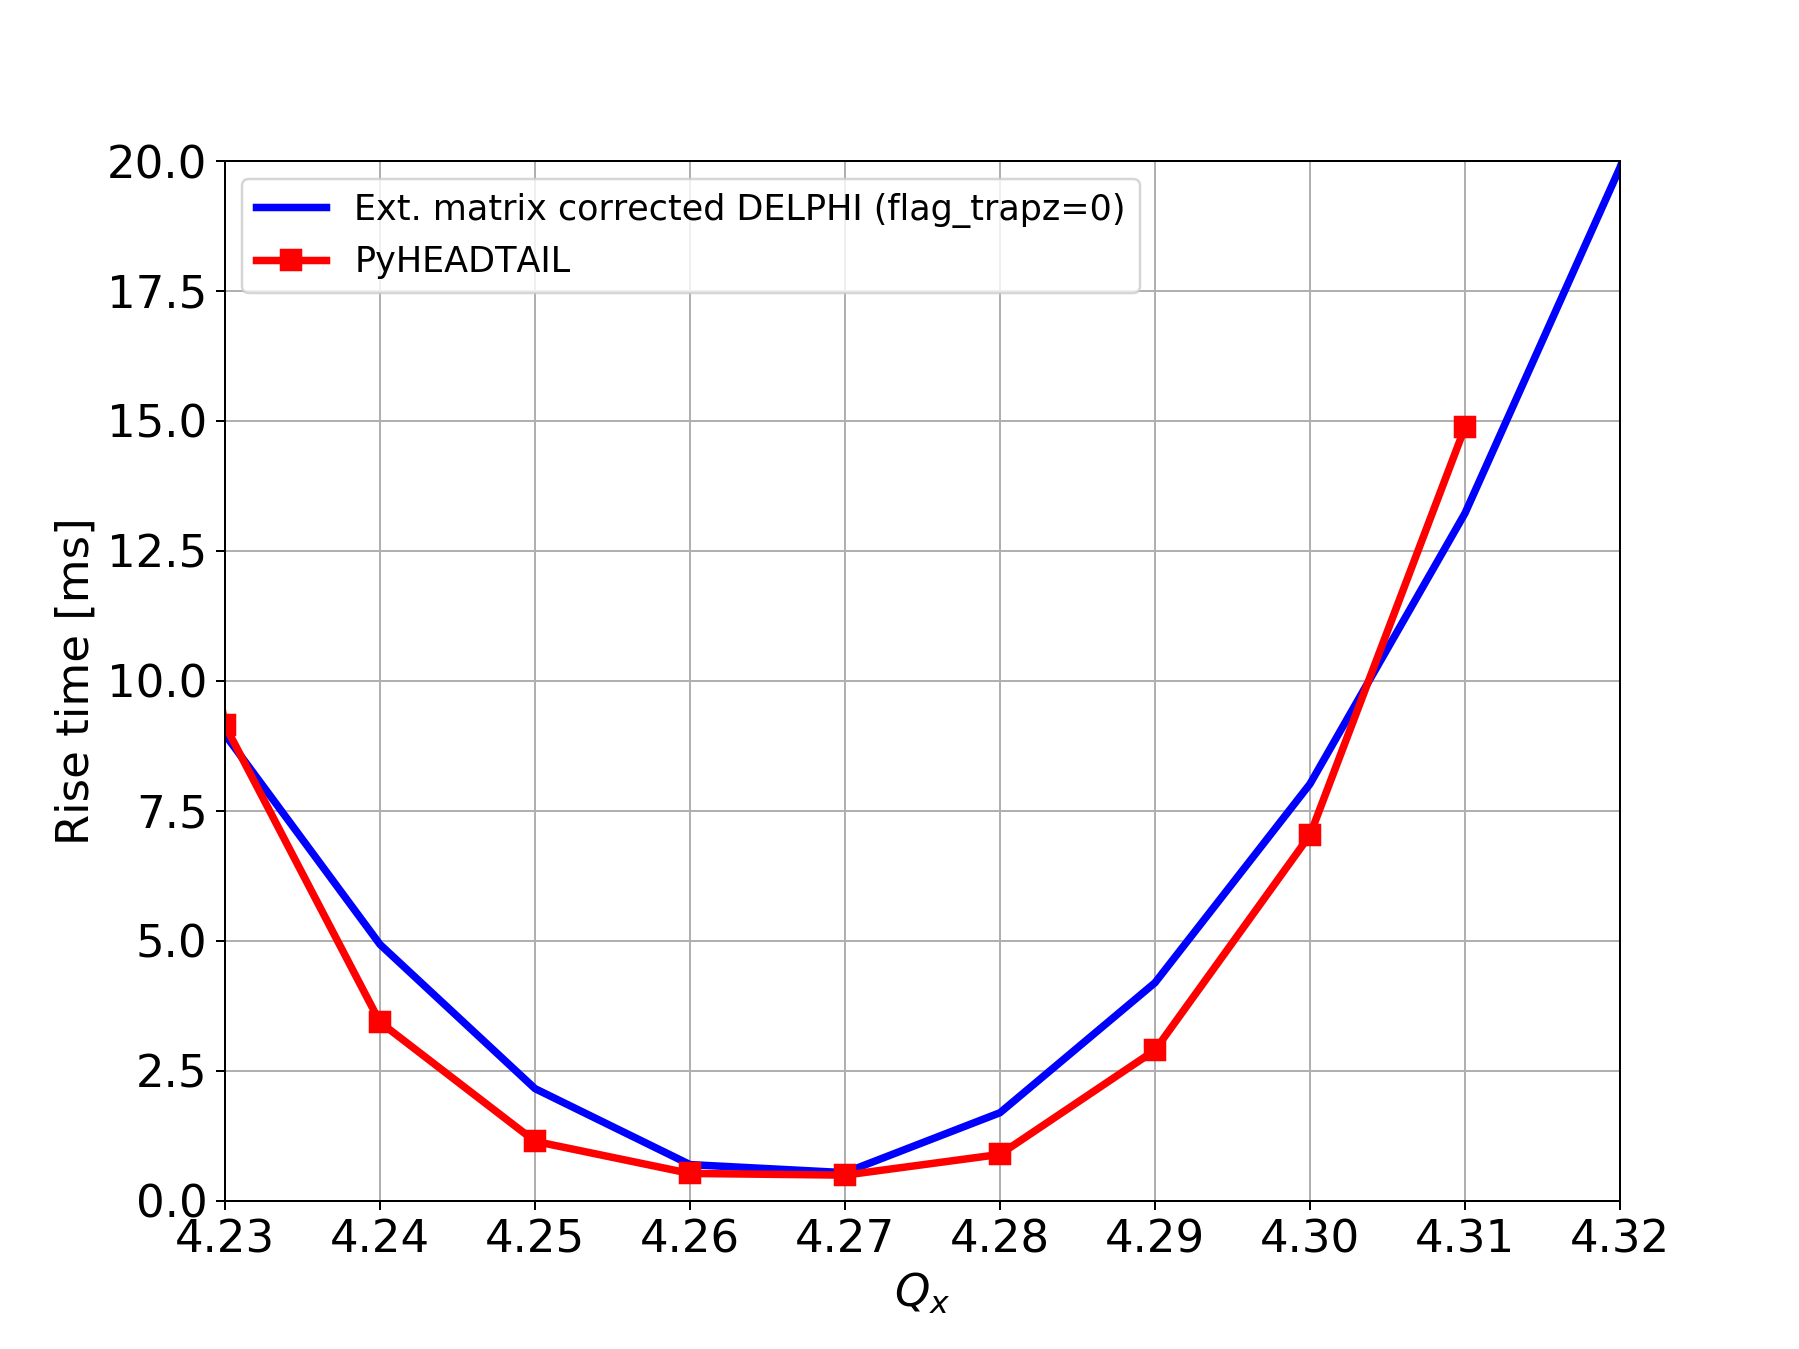

<IPython.core.display.Javascript object>


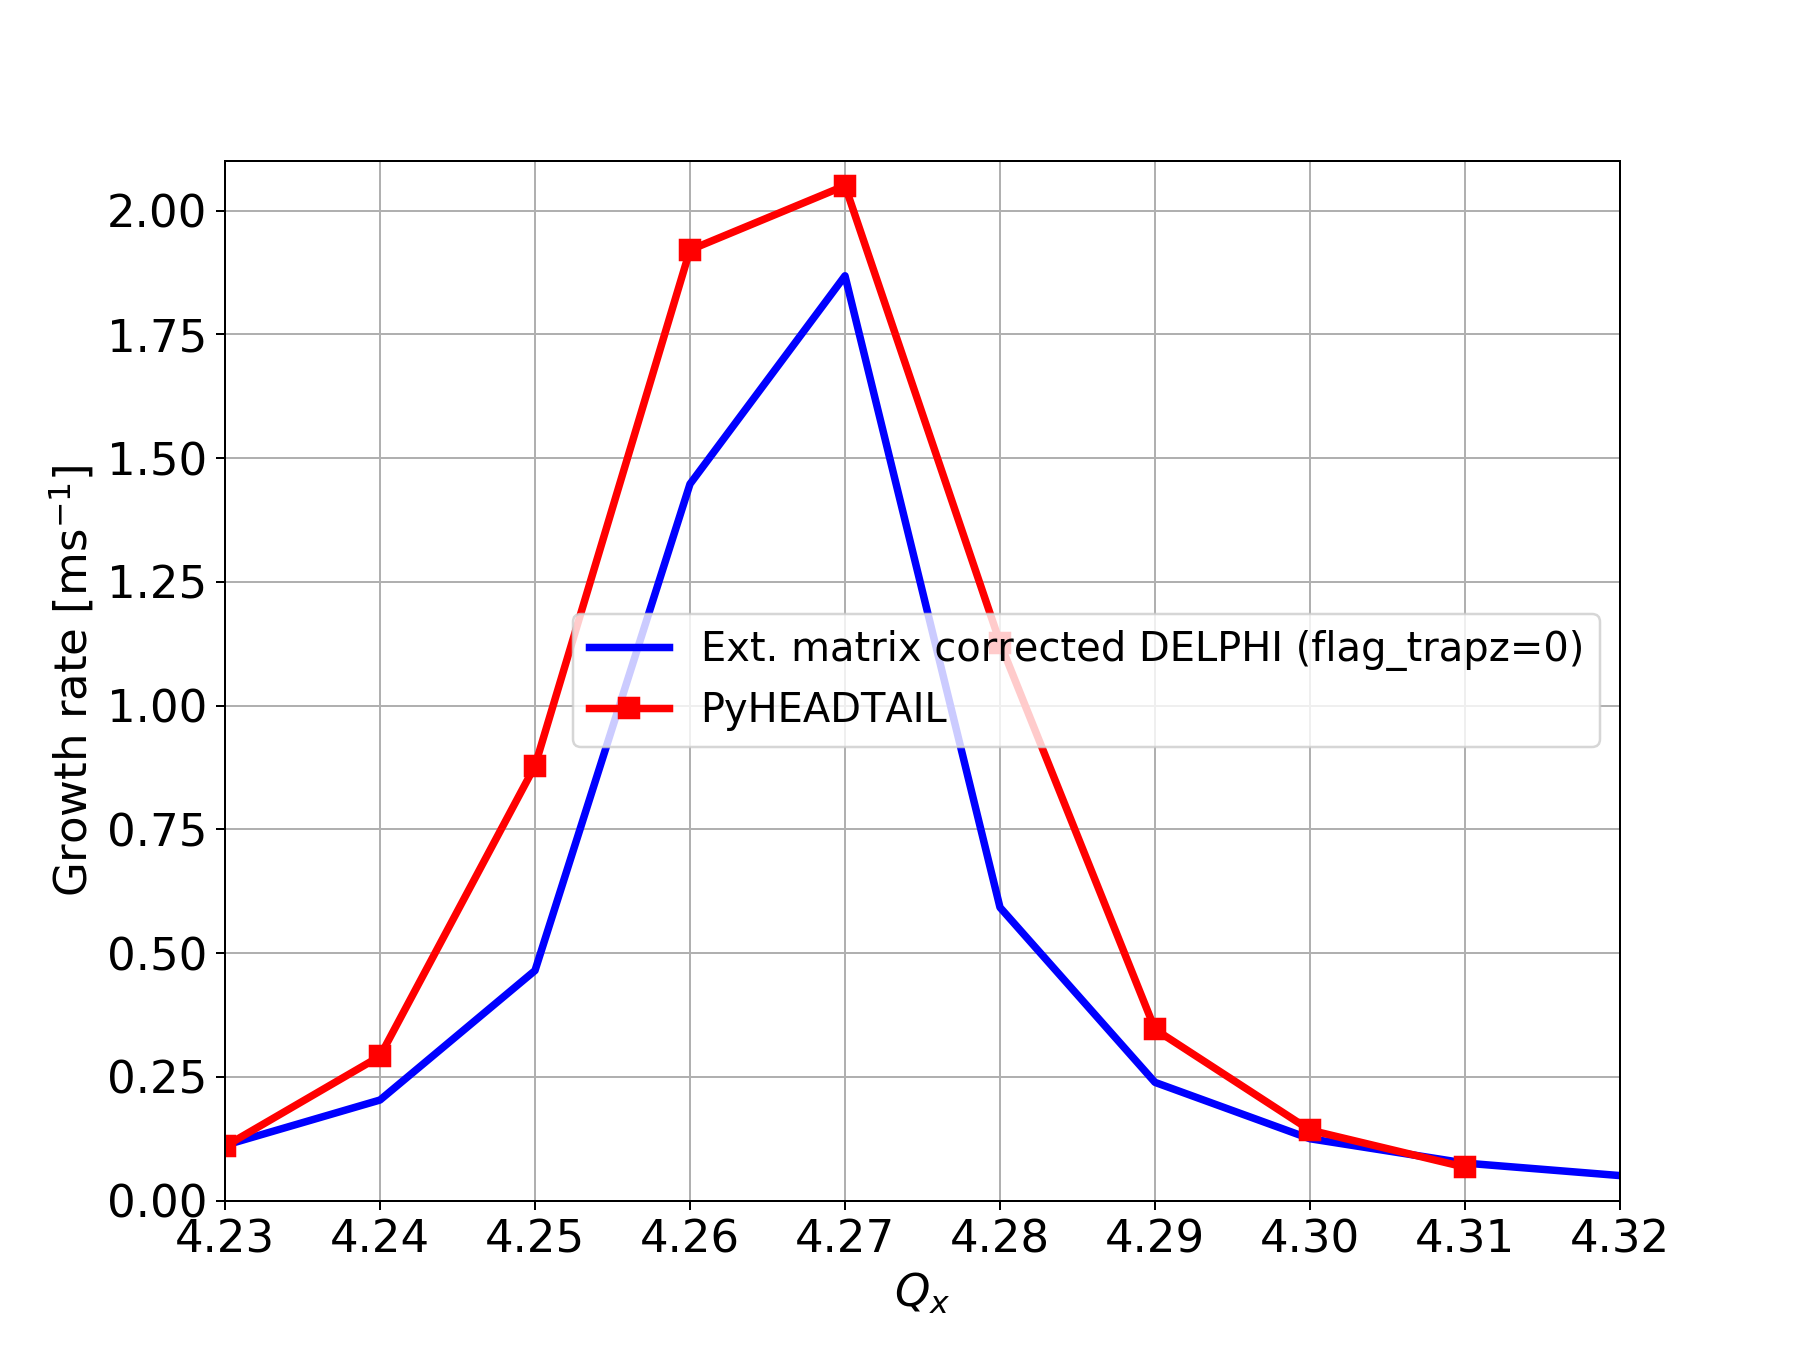

In [19]:
lab = r"Ext. matrix corrected"

# PyHEADTAIL with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qx = [4.17,  4.18,  4.19,  4.2 ,  4.22,  4.23,  4.24,  4.25,  4.26,
        4.27,  4.28,  4.29,  4.3 ,  4.31,  4.36,  4.37,  4.41,  4.42,
        4.43,  4.44,  4.45,  4.46,  4.47,  4.48]
tau = [2.94816758e+02,  -2.73927555e+03,  -2.52865266e+02,
         4.54159568e+01,   2.65136856e+01,   9.14142010e+00,
         3.43054562e+00,   1.13875757e+00,   5.20761672e-01,
         4.87766411e-01,   8.87470409e-01,   2.89201778e+00,
         7.03217664e+00,   1.48787595e+01,  -1.42901661e+02,
         9.32281186e+01,  -6.23087358e+01,  -2.96131931e+02,
         1.00062446e+02,  -1.45910813e+02,  -1.72731598e+03,
        -6.47571274e+01,   6.23678388e+01,   5.59967966e+01]         
qx = np.array(qx)
tau = np.array(tau)

# DELPHI simulations with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qxD = [4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.30]
tauD = [11.45, 6.2, 2.65, 0.66, 0.61, 2.08, 5.13, 9.82]
qxD = np.array(qxD)
tauD = np.array(tauD)

dQ_imag  = np.array([np.imag(np.squeeze(dQ)[0]) for dQ in tuneshifts])
write_ncol_file(os.path.join(result_folder,'dQimag_PSB_HOM.txt'),
                np.hstack((Qxscan.reshape(-1,1),dQ_imag.reshape(-1,1))),header='Qx\tdQ_imag')
    
msk = (tau<0) | (tau>50)

# plot rise times
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e3/(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab)) 
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Rise time [ms]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,20.])
plt.legend(fontsize=14)

# plot growth rates
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e-3*(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],1./tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,1./tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab))
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Growth rate [ms$^{{-1}}$]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,2.1])
plt.legend(fontsize=16)

## Optimized convergence DELPHI calculation with flag_trapz=0 (scan in Qx)
It still fails miserably with flag_trapz=1 (nan or inf in matrix)

In [32]:
reload(sys.modules['DELPHI'])
from DELPHI import *

In [36]:
g, a, b = longdistribution_decomp(machine.taub, typelong='Gaussian')

print "Qy= {}, omega0={}, Qs= {}, gamma={}, eta={}, taub={}".format(machine.Qy,machine.omega0,machine.Qs,
                                                                    machine.gamma,machine._eta,machine.taub)

kmax = 1 # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot = 50; # number of kept and plotted eigenvalues (in TMCI plot)
# DELPHI convergence criteria
crit = 5e-5
abseps = 1e-4
flag_trapz = 0
optimized_convergence = True

# Chromaticity
#Qp = -3.5#-0.73*machine.Qx  # horizontal chroma
#omegaksi = Qp*machine.omega0 / machine._eta

# Number of bunches
M = 1
# Damper gain and phase
damp = 0.0
dphase = 0
# Intensity scan
#Nbscan = np.arange(0, 5.2e11, 2e10)
Nbscan = [4e12]
Qxscan = np.arange(4.17, 4.49, 0.01)# 4.10, 4.45, 0.01)
#Qxscan = np.arange(4.23, 4.35, 0.01)# 4.10, 4.45, 0.01)

tuneshifts = []
#eigenvectors = []

scenario = 'Eirini_opt_conv_DELPHI_beta_compliant'
result_folder = os.path.join(ResultDir,scenario)
os.system("mkdir -p "+result_folder)

DELPHI_params = {'Mscan': [M],
                 'Qxscan': Qxscan.tolist(),
                 'Qpscan': (-0.73*Qxscan).tolist(),
                 'dampscan': [damp],
                 'Nbscan': Nbscan,
                 'omegasscan': [machine.omegas],
                 'dphasescan': [dphase],
                 'omega0': machine.omega0,
                 'Qy': machine.Qy,
                 'gamma': machine.gamma, 'eta': machine._eta,
                 'a': a,'b': b,
                 'taub': machine.taub, 'g': g.tolist(),
                 'planes': ['x'],
                 'nevery': nevery,
                 'particle': 'proton',
                 'flagnorm': flagnorm,'flagdamperimp': flagdamperimp,
                 'd': d, 'freqd': freqd,
                 'kmax': kmax, 'kmaxplot': kmaxplot,
                 'crit': crit, 'abseps': abseps, 
                 'flagm0': flagm0, 'flageigenvect': flageigenvect,
                 'flag_trapz': flag_trapz,
                 'optimized_convergence': optimized_convergence,
                 'lxplusbatch': None,
                 'comment': "{}_{}".format(machine_name,scenario),
                 'queue': '2nd', 'dire': result_folder+'/',
                 'flagQpscan_outside': True,
                 }

with open(os.path.join(result_folder,'DELPHI_parameters.json'), 'w') as f:
    f.write(json.dumps(DELPHI_params,indent=4))


print (machine.taub / 4) * machine.beta * clight
t0 = ti.clock()
for Qx in Qxscan:
    
    print "="*60
    Qp = -0.73*Qx
    #Qp = -3.5 # the value needed to get back (some of) Eirini's DELPHI results
    dQ, _ = DELPHI_wrapper(imp_mod, [M], [Qp], [damp], Nbscan, [machine.omegas], [dphase], machine.omega0,
                           Qx, machine.Qy, machine.gamma, machine._eta, a, b, machine.taub, g, ['x'],
                           nevery=nevery, particle='proton', flagnorm=flagnorm, flagdamperimp=flagdamperimp,
                           d=d, freqd=freqd, kmax=kmax, kmaxplot=kmaxplot, flag_trapz=flag_trapz,
                           crit=crit, abseps=abseps, flagm0=flagm0, flageigenvect=flageigenvect,
                           lxplusbatch=None, comment="{}_{}_{}".format(machine_name,scenario,float_to_str(Qx)),
                           queue='2nd', dire=result_folder+'/', flagQpscan_outside=True,
                           optimized_convergence=optimized_convergence)
    
    print "Qx={}, Qpx={}: most unstable mode dQ={}".format(Qx,Qp,np.squeeze(dQ)[0])
    tuneshifts.append(dQ)
    #eigenvectors.append(v)

t1 = ti.clock()
print("Elapsed time: {} s".format(t1-t0))

Qy= 4.2, omega0=6233102.82351, Qs= 0.0016953, gamma=1.17052622918, eta=-0.669696870079, taub=4.8e-07
18.6981617627037
Qp= -3.0441 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 14 , nmaxi= 22 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.17, Qpx=-3.0441: most unstable mode dQ=(2.80534857329e-05-2.72816075718e-06j)
Qp= -3.0513999999999997 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 14 , nmaxi= 22 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.18, Qpx=-3.0514: most unstable mode dQ=(3.14259958519e-05-3.39176032757e-06j)
Qp= -3.0586999999999995 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 22 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.19, Qpx=-3.0587: most unstable mode dQ=(3.56590058522e-05-4.3229995076e-06j)
Qp= -3.0659999999999994 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 15 , nmaxi= 21 , kmode= 0 , Most unstable coupled-b

Qp= -3.2411999999999956 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 14 , nmaxi= 21 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.44, Qpx=-3.2412: most unstable mode dQ=(-0.00679495244871-5.05348463061e-07j)
Qp= -3.2484999999999955 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 14 , nmaxi= 21 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.45, Qpx=-3.2485: most unstable mode dQ=(-0.00679438443708-4.31333113482e-07j)
Qp= -3.2557999999999954 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 14 , nmaxi= 21 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.46, Qpx=-3.2558: most unstable mode dQ=(-0.00679389797704-3.64568532673e-07j)
Qp= -3.2630999999999952 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 14 , nmaxi= 21 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.47, Qpx=-3.2631: most unstable mode dQ=(-0.00848599221347-3.05647827879e-07j)
Qp= -3.2

### Plot rise times vs Qx, and comparison with PyHEADTAIL

<IPython.core.display.Javascript object>


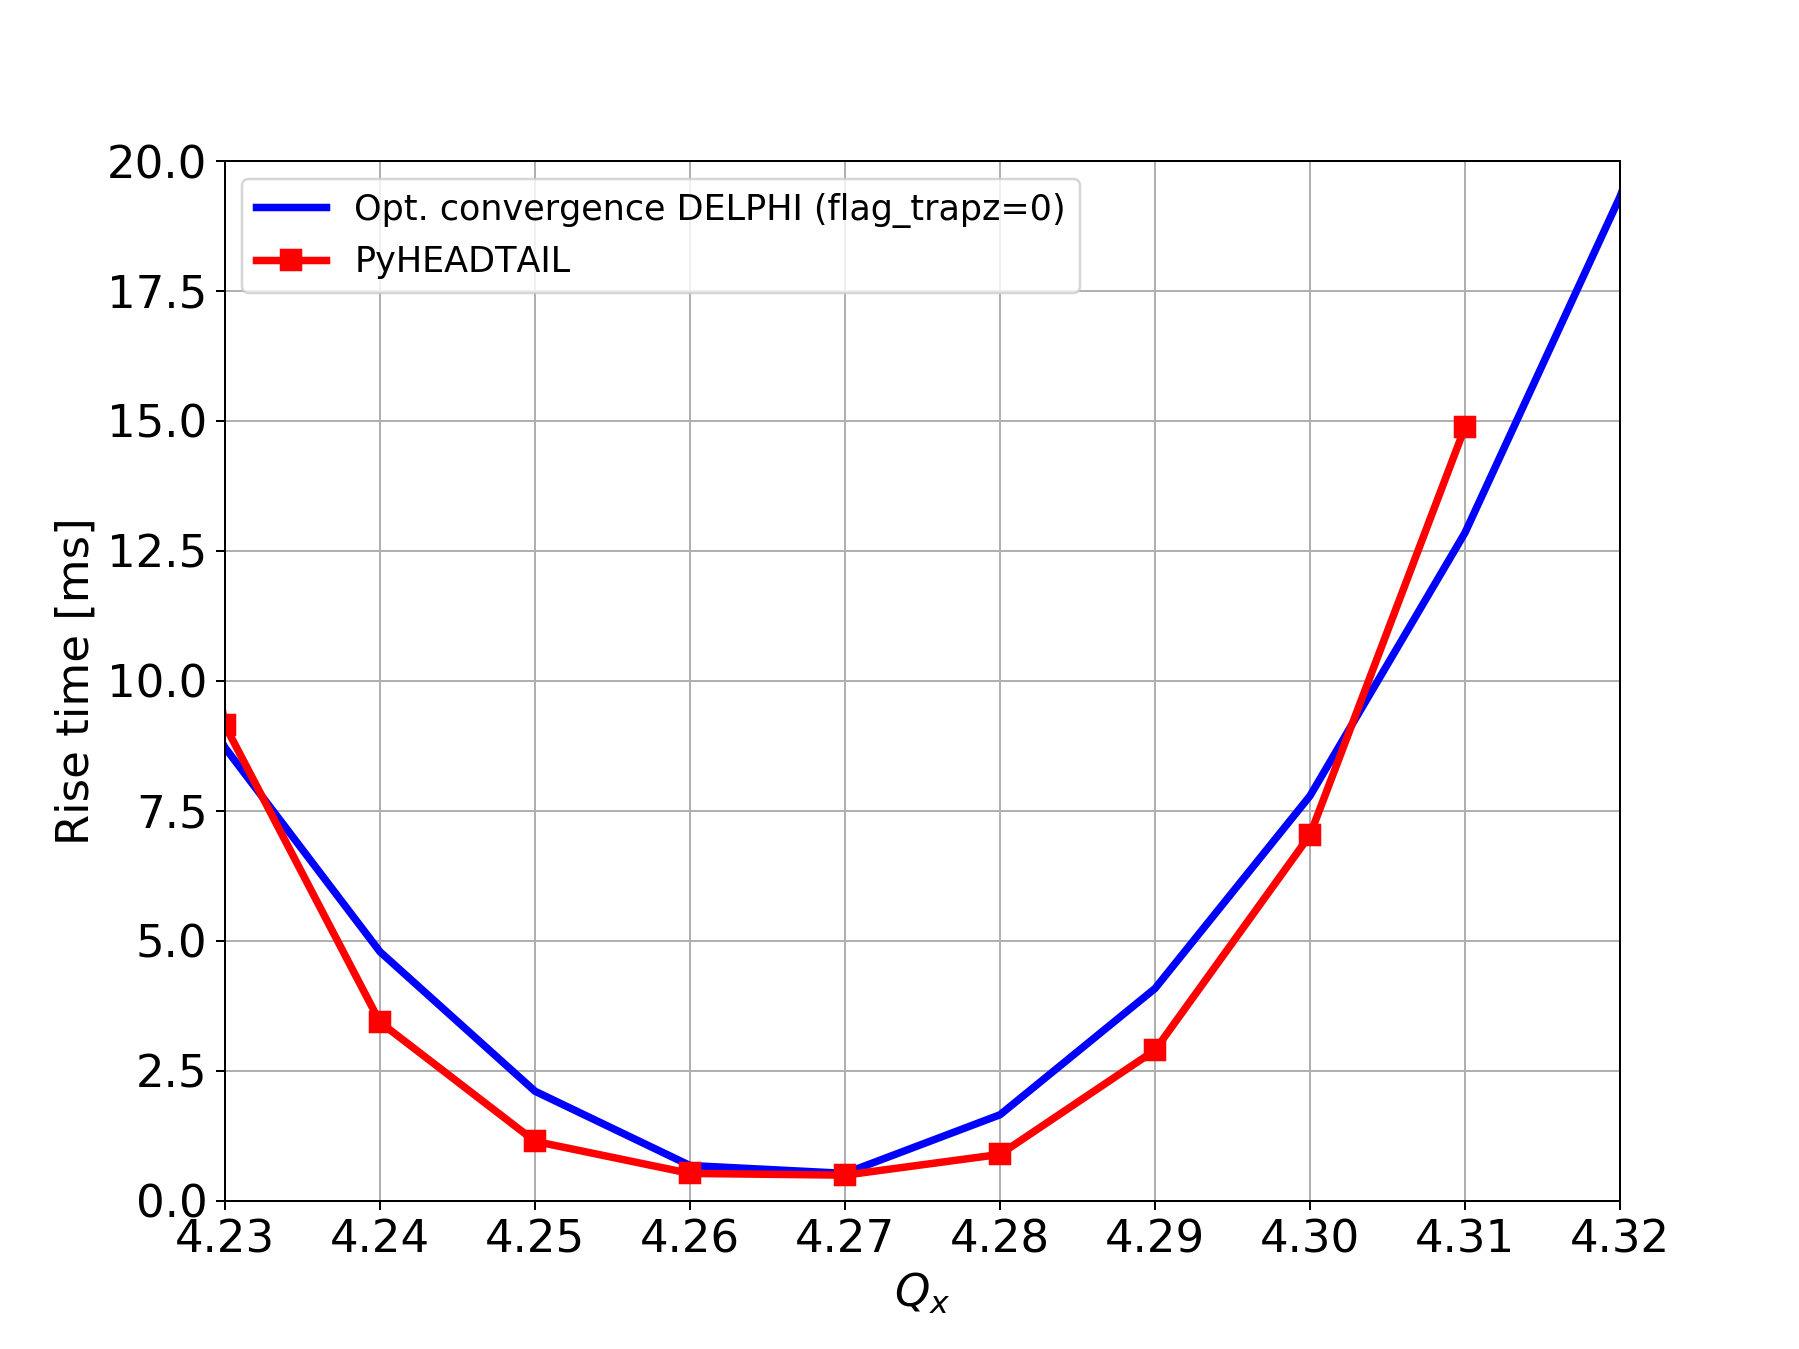

<IPython.core.display.Javascript object>


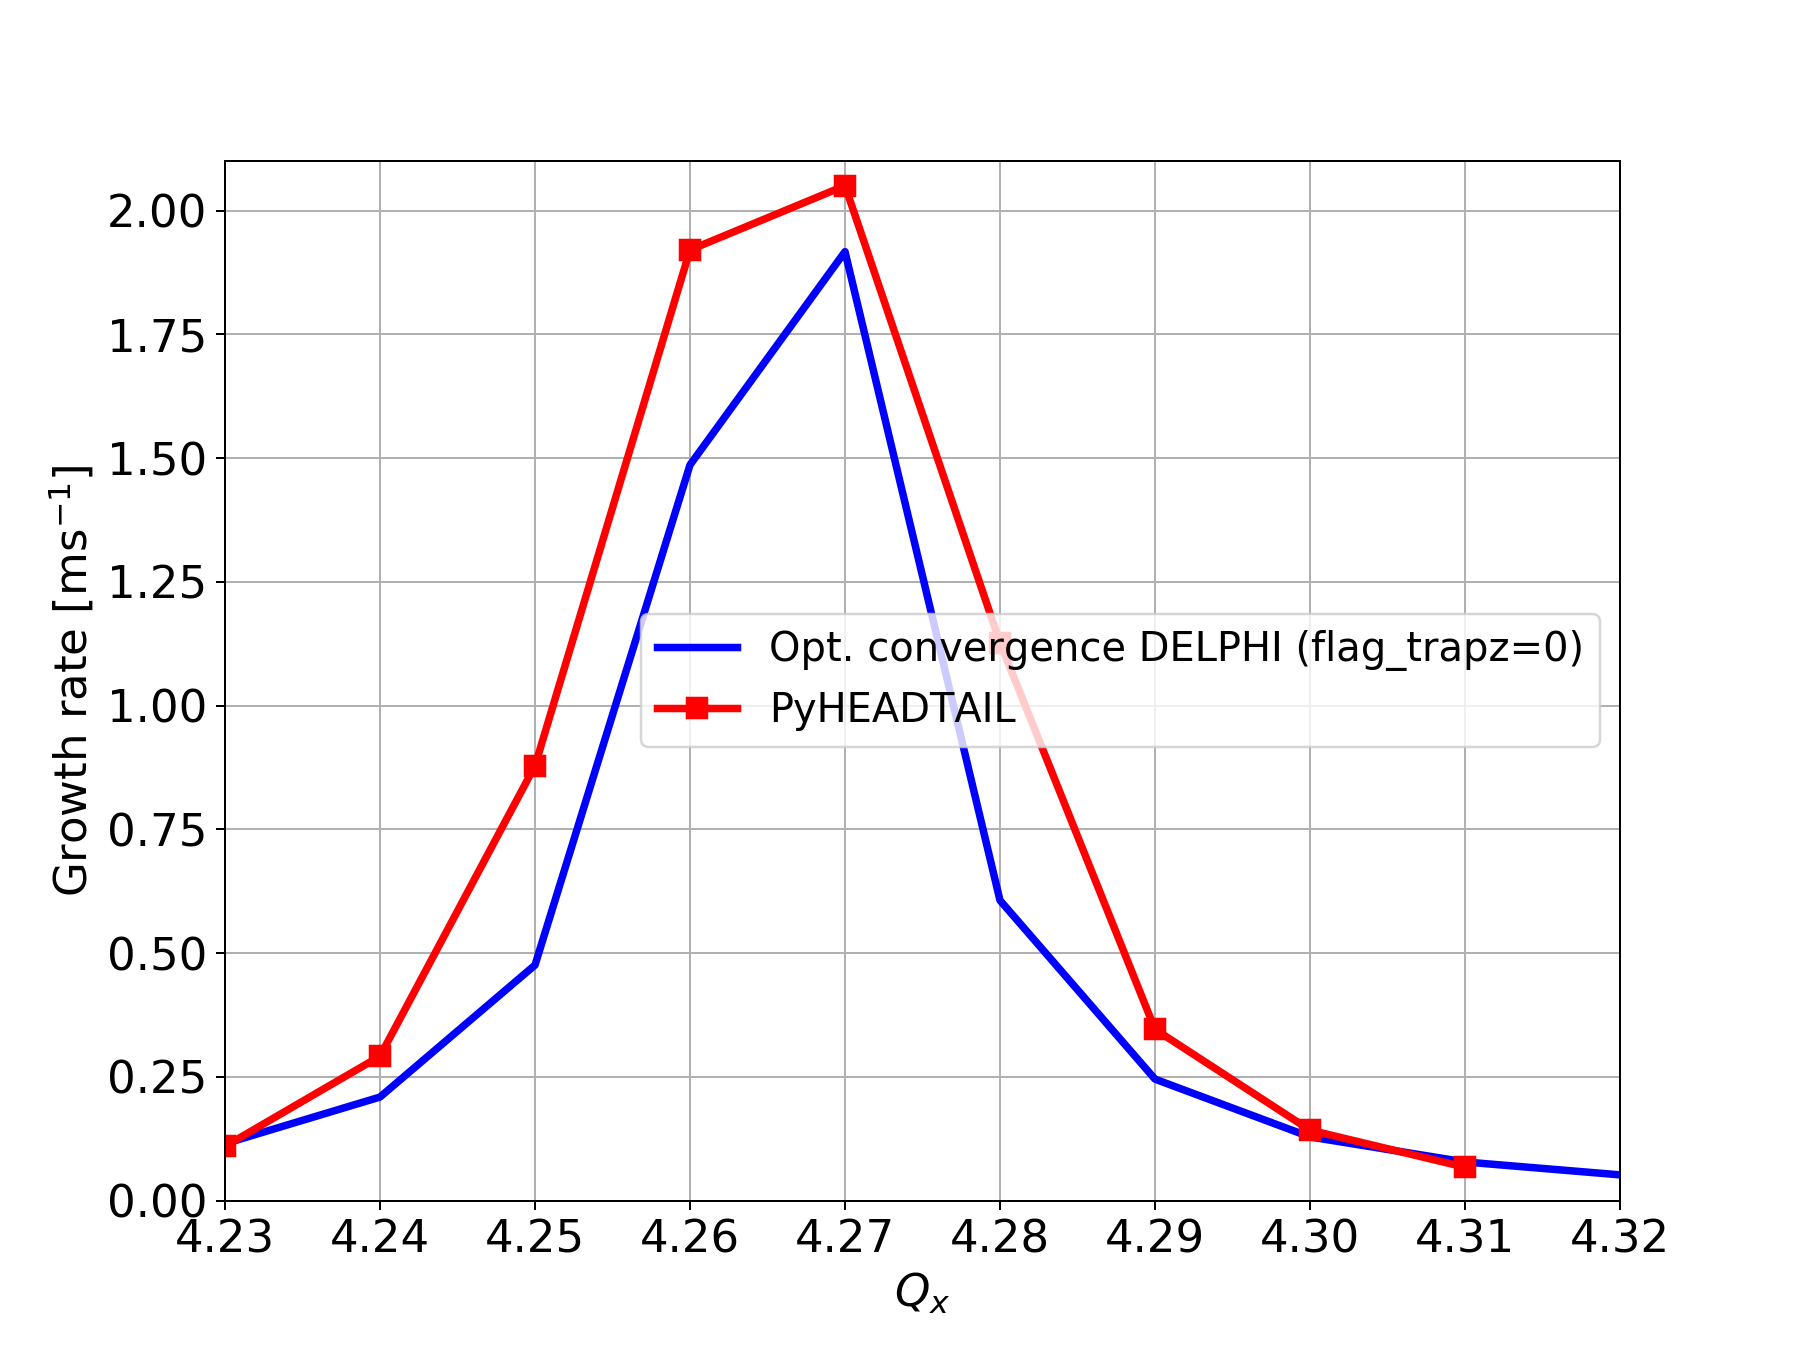

In [41]:
lab = r"Opt. convergence"

# PyHEADTAIL with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qx = [4.17,  4.18,  4.19,  4.2 ,  4.22,  4.23,  4.24,  4.25,  4.26,
        4.27,  4.28,  4.29,  4.3 ,  4.31,  4.36,  4.37,  4.41,  4.42,
        4.43,  4.44,  4.45,  4.46,  4.47,  4.48]
tau = [2.94816758e+02,  -2.73927555e+03,  -2.52865266e+02,
         4.54159568e+01,   2.65136856e+01,   9.14142010e+00,
         3.43054562e+00,   1.13875757e+00,   5.20761672e-01,
         4.87766411e-01,   8.87470409e-01,   2.89201778e+00,
         7.03217664e+00,   1.48787595e+01,  -1.42901661e+02,
         9.32281186e+01,  -6.23087358e+01,  -2.96131931e+02,
         1.00062446e+02,  -1.45910813e+02,  -1.72731598e+03,
        -6.47571274e+01,   6.23678388e+01,   5.59967966e+01]         
qx = np.array(qx)
tau = np.array(tau)

# DELPHI simulations with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini)
qxD = [4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.30]
tauD = [11.45, 6.2, 2.65, 0.66, 0.61, 2.08, 5.13, 9.82]
qxD = np.array(qxD)
tauD = np.array(tauD)

dQ_imag  = np.array([np.imag(np.squeeze(dQ)[0]) for dQ in tuneshifts])
write_ncol_file(os.path.join(result_folder,'dQimag_PSB_HOM.txt'),
                np.hstack((Qxscan.reshape(-1,1),dQ_imag.reshape(-1,1))),header='Qx\tdQ_imag')
    
msk = (tau<0) | (tau>50)

# plot rise times
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e3/(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab)) 
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Rise time [ms]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,20.])
plt.legend(fontsize=14)

# plot growth rates
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e-3*(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],1./tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,1./tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab))
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Growth rate [ms$^{{-1}}$]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,2.1])
plt.legend(fontsize=16)

<IPython.core.display.Javascript object>


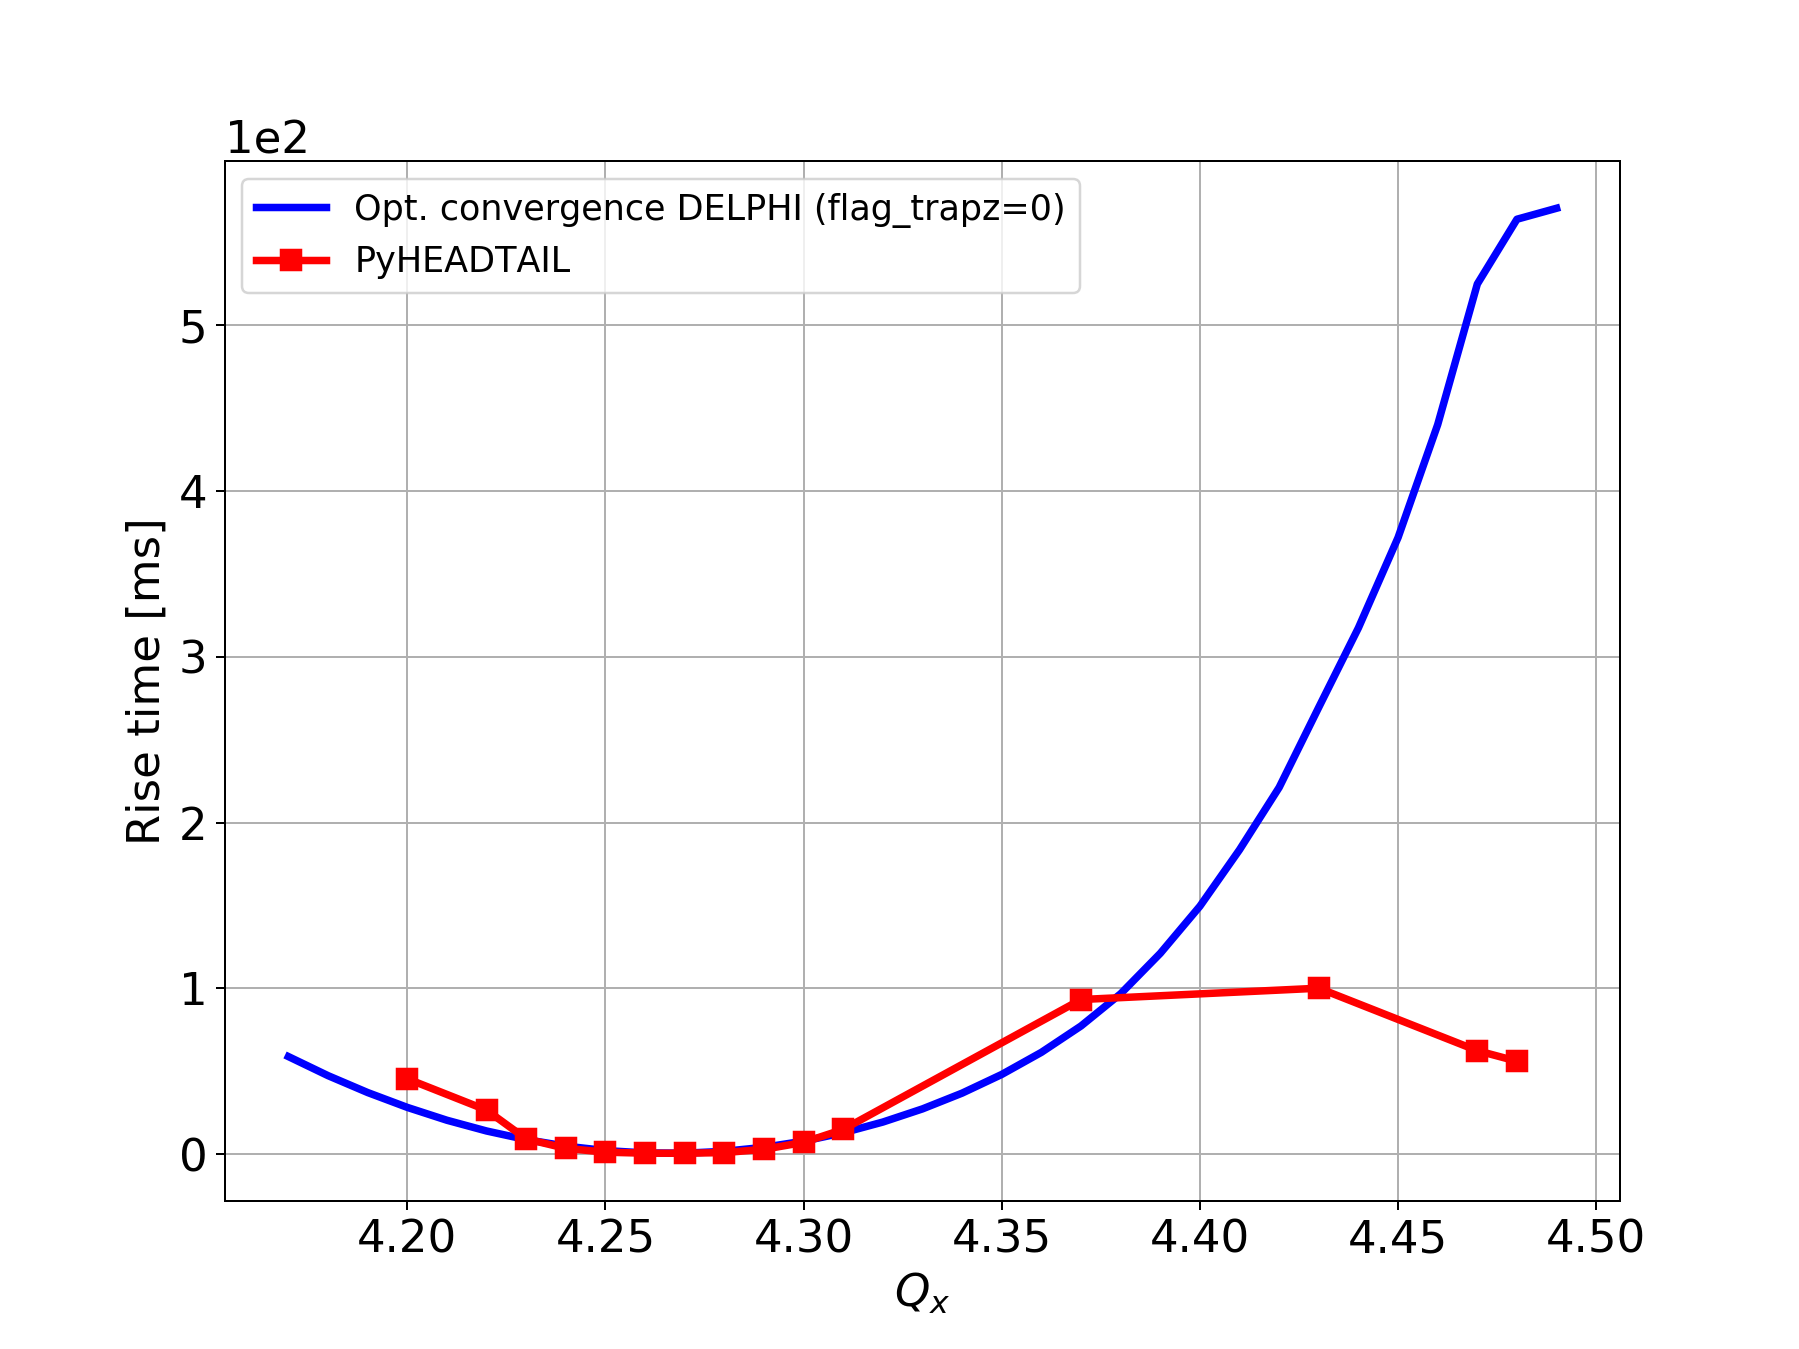

<IPython.core.display.Javascript object>


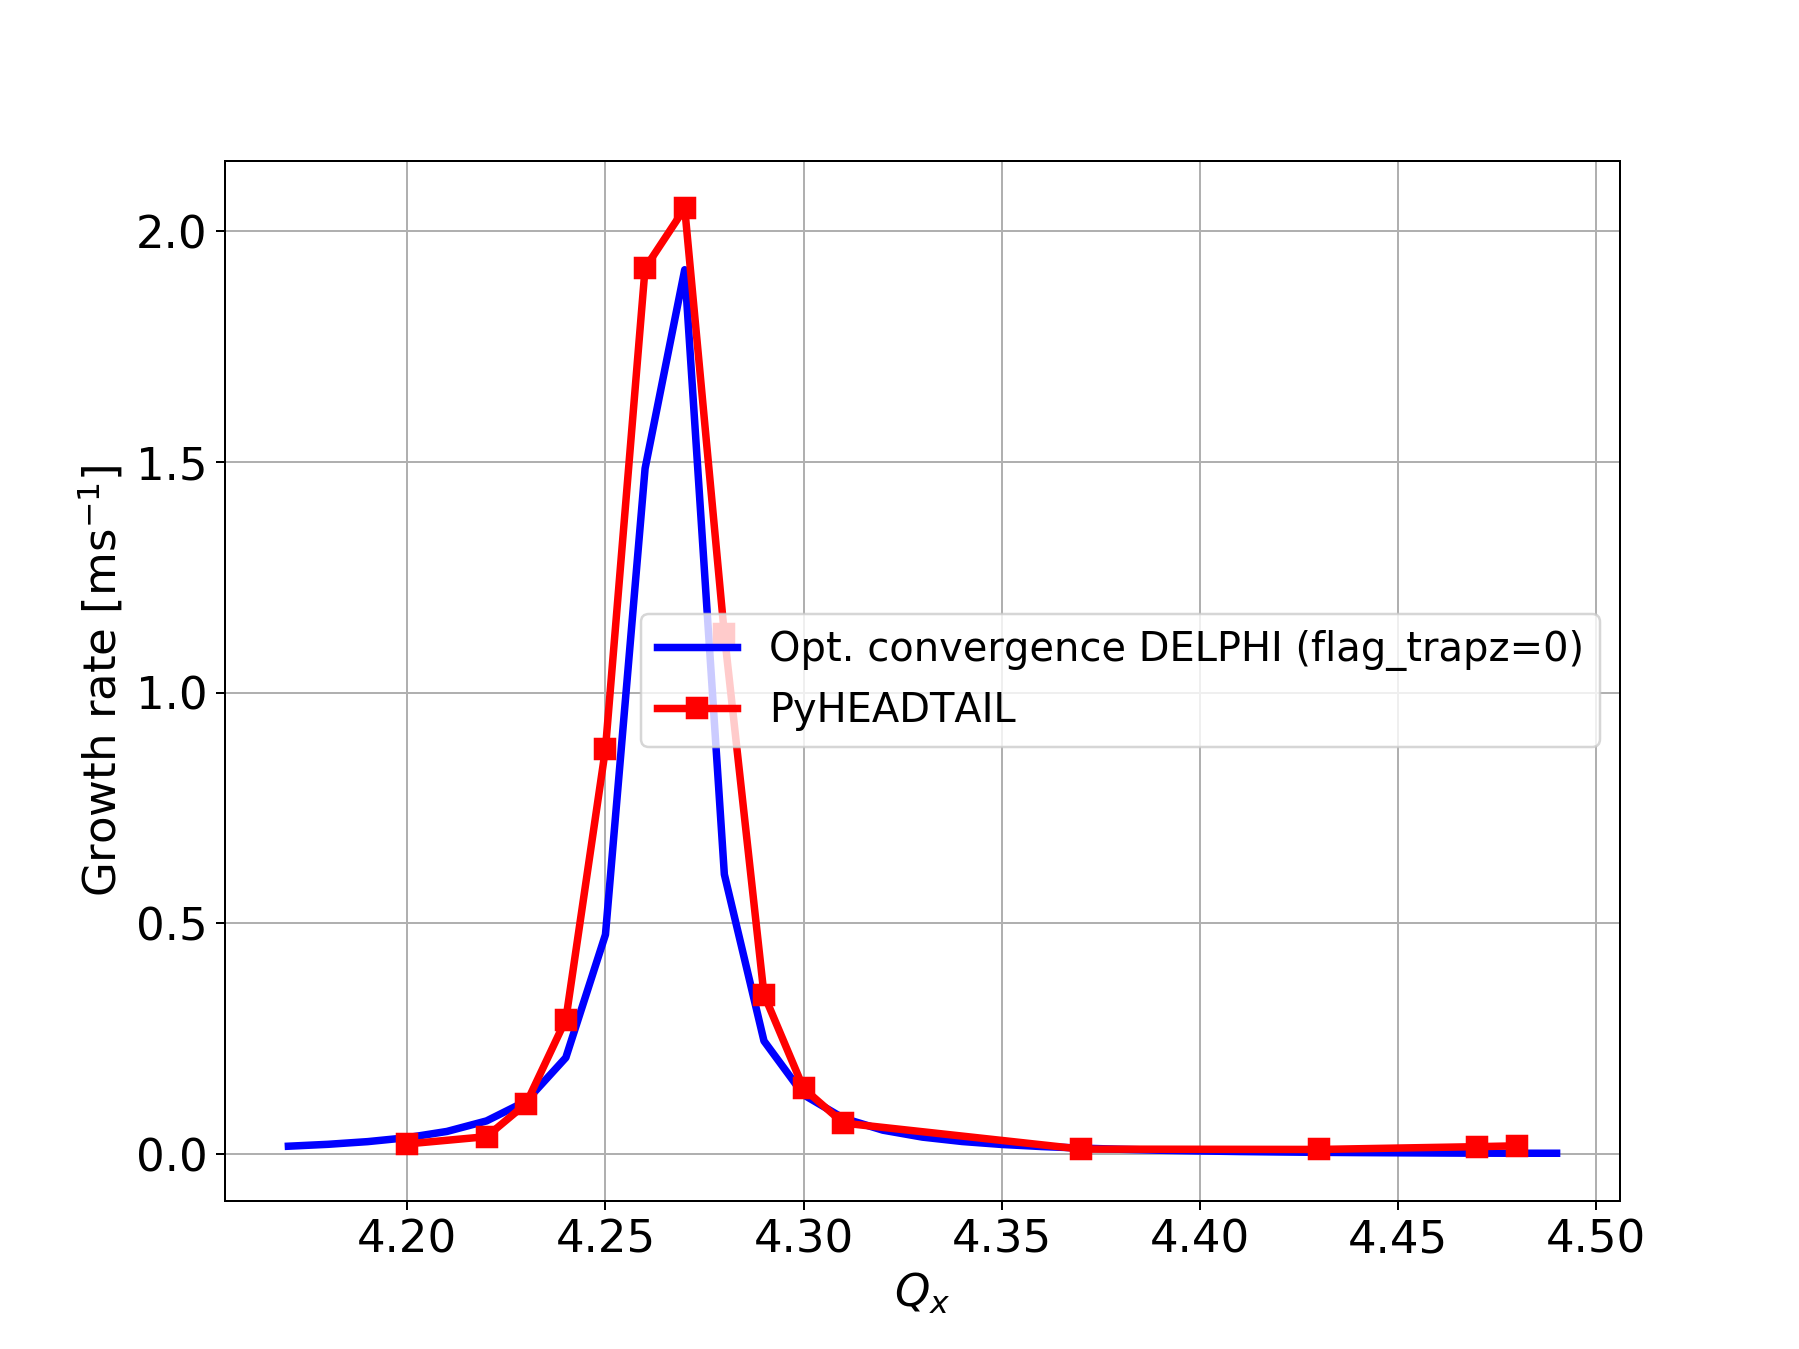

In [42]:
msk = (tau<0) | (tau>101)

# plot rise times
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e3/(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab)) 
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Rise time [ms]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
#plt.axis([4.23,4.32,0.,20.])
plt.legend(fontsize=14)

# plot growth rates
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e-3*(machine.omega0*dQ_imag),'b',lw=3,
         label=r"{} DELPHI (flag_trapz={})".format(lab,flag_trapz))

plt.plot(qx[~msk],1./tau[~msk],'r',marker='s',lw=3,ms=8,
         label=r"PyHEADTAIL")

#plt.plot(qxD,1./tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab))
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Growth rate [ms$^{{-1}}$]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
#plt.axis([4.23,4.32,0.,2.1])
plt.legend(fontsize=16)

## New optimized convergence DELPHI calculations with parabolic line density

In [15]:
reload(sys.modules['DELPHI'])
from DELPHI import *

### Calculations

In [8]:
lxplusbatch = None
taub = 503e-9
g, a, b = longdistribution_decomp(taub, typelong='parabolicline')
len(g)

39

In [9]:
print "Qy= {}, omega0={}, Qs= {}, gamma={}, eta={}, taub={}".format(machine.Qy,machine.omega0,machine.Qs,
                                                                    machine.gamma,machine._eta,taub)

kmax = 1 # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot = 50; # number of kept and plotted eigenvalues (in TMCI plot)
# DELPHI convergence criteria
crit = 5e-5
abseps = 1e-4
flag_trapz = 0
flagm0 = False
flageigenvect = True
optimized_convergence = True

# Chromaticity
#Qp = -3.5#-0.73*machine.Qx  # horizontal chroma
#omegaksi = Qp*machine.omega0 / machine._eta

# Number of bunches
M = 1
# Damper gain and phase
damp = 0.0
dphase = 0
# Intensity scan
#Nbscan = np.arange(0, 5.2e11, 2e10)
Nbscan = [4e12]
#Qxscan = np.arange(4.17, 4.49, 0.01)# 4.10, 4.45, 0.01)
Qxscan = np.arange(4.2, 4.3, 0.01)
Qxscan = np.array([4.24])

scenario = 'Eirini_new_DELPHI_parabolicline'
result_folder = os.path.join(ResultDir,scenario)
os.system("mkdir -p "+result_folder)

if lxplusbatch in [None,'launch']:
    
    tuneshifts = []
    eigenvectors = []

    DELPHI_params = {'Mscan': [M],
                     'Qxscan': Qxscan.tolist(),
                     'Qpscan': (-0.73*Qxscan).tolist(),
                     'dampscan': [damp],
                     'Nbscan': Nbscan,
                     'omegasscan': [machine.omegas],
                     'dphasescan': [dphase],
                     'omega0': machine.omega0,
                     'Qy': machine.Qy,
                     'gamma': machine.gamma, 'eta': machine._eta,
                     'a': a,'b': b,
                     'taub': taub, 'g': g.tolist(),
                     'planes': ['x'],
                     'nevery': nevery,
                     'particle': 'proton',
                     'flagnorm': flagnorm,'flagdamperimp': flagdamperimp,
                     'd': d, 'freqd': freqd,
                     'kmax': kmax, 'kmaxplot': kmaxplot,
                     'crit': crit, 'abseps': abseps, 
                     'flagm0': flagm0, 'flageigenvect': flageigenvect,
                     'flag_trapz': flag_trapz,
                     'optimized_convergence': optimized_convergence,
                     'lxplusbatch': None,
                     'comment': "{}_{}".format(machine_name,scenario),
                     'queue': '2nd', 'dire': result_folder+'/',
                     'flagQpscan_outside': True,
                     }

    with open(os.path.join(result_folder,'DELPHI_parameters.json'), 'w') as f:
        f.write(json.dumps(DELPHI_params,indent=4))


    print (taub / 4) * machine.beta * clight
    t0 = ti.clock()
    for Qx in Qxscan:

        print "="*60
        Qp = -0.73*Qx
        #Qp = -3.5 # the value needed to get back (some of) Eirini's DELPHI results
        dQ, v = DELPHI_wrapper(imp_mod, [M], [Qp], [damp], Nbscan, [machine.omegas], [dphase], machine.omega0,
                               Qx, machine.Qy, machine.gamma, machine._eta, a, b, taub, g, ['x'],
                               nevery=nevery, particle='proton', flagnorm=flagnorm, flagdamperimp=flagdamperimp,
                               d=d, freqd=freqd, kmax=kmax, kmaxplot=kmaxplot, flag_trapz=flag_trapz,
                               crit=crit, abseps=abseps, flagm0=flagm0, flageigenvect=flageigenvect,
                               lxplusbatch=lxplusbatch, comment="{}_{}_{}".format(machine_name,scenario,float_to_str(Qx)),
                               queue='2nd', dire=result_folder+'/', flagQpscan_outside=True,
                               optimized_convergence=optimized_convergence)

        print "Qx={}, Qpx={}: most unstable mode dQ={}".format(Qx,Qp,np.squeeze(dQ)[0])
        tuneshifts.append(np.squeeze(dQ)[0])
        eigenvectors.append(np.squeeze(v).tolist()[:,:,0])

    t1 = ti.clock()
    print("Elapsed time: {} s".format(t1-t0))
    
if lxplusbatch in [None,'retrieve']:
    np.save(os.path.join(result_folder,'TuneshiftQx.npy'), np.array(tuneshifts))
    np.save(os.path.join(result_folder,'Qxscan.npy'), Qxscan)
    np.save(os.path.join(result_folder,'Eigenvectors.npy'), np.array(eigenvectors))

    dQ_imag  = np.array([np.imag(dQ) for dQ in tuneshifts])
    write_ncol_file(os.path.join(result_folder,'dQimag_PSB_HOM.txt'),
                    np.hstack((Qxscan.reshape(-1,1),dQ_imag.reshape(-1,1))),header='Qx\tdQ_imag')

if lxplusbatch=='restore':
    tuneshifts = np.load(os.path.join(result_folder,'TuneshiftQx.npy'))
    Qxscan = np.load(os.path.join(result_folder,'Qxscan.npy'))
    eigenvectors = np.load(os.path.join(result_folder,'Eigenvectors.npy'))
    dQ_imag  = np.array([np.imag(dQ) for dQ in tuneshifts])

Qy= 4.2, omega0=6233102.82351, Qs= 0.0016953, gamma=1.17052622918, eta=-0.669696870079, taub=5.03e-07
19.594115347166586
Qp= -3.0952 , M= 1 , d= 0.0 , Nb= 4e+12 , omegas= 10566.979216700205 , dphase= 0
lmaxi= 13 , nmaxi= 25 , kmode= 0 , Most unstable coupled-bunch mode:  0
Qx=4.24, Qpx=-3.0952: most unstable mode dQ=(0.00178413775838-3.02840880181e-05j)
Elapsed time: 436.56361 s


In [18]:
np.squeeze(v).tolist()

array([[[ 6.44092981e-07-2.18140878e-07j,
          2.59650759e-07-8.31158788e-08j,
          1.74654670e-07+6.14101327e-07j, ...,
          2.66196677e-10-2.59532744e-09j,
          1.56829165e-09-3.09346403e-10j,
          1.27536450e-09-2.76145617e-10j],
        [ 5.59067284e-07-1.94504012e-07j,
          2.24916874e-07-7.40970026e-08j,
          1.56318209e-07+5.32150666e-07j, ...,
          2.05824434e-10-5.30741704e-09j,
         -3.39769883e-09-1.74446707e-10j,
         -3.00858478e-09-1.59439809e-10j],
        [ 4.69235863e-07-1.72986279e-07j,
          1.87624256e-07-6.60302237e-08j,
          1.40279552e-07+4.45198596e-07j, ...,
          2.12985800e-10-5.99651585e-09j,
         -6.40942847e-09-7.71518176e-11j,
         -5.58728882e-09-7.41125329e-11j],
        ...,
        [ 6.22673168e-09-2.02721645e-09j,
          2.49328366e-09-7.69139106e-10j,
          1.61065689e-09+5.89088076e-09j, ...,
          8.19390945e-13-2.64502452e-11j,
         -6.14740652e-11-1.08764107e-12j

### Plot headtail signal

In [18]:
tau = np.linspace(0, taub, 1000)
r = clight * machine.beta * tau

ymax=0.
ymin=0.
for Qx,dQ,eigenvector in zip(Qxscan,tuneshifts,eigenvectors):
    
    Qp = -0.73*Qx
    l,n = eigenvector.shape
    lmax = (l-1)/2
    nmax = n-1
    Rl_table = R_computation_v2(eigenvector.reshape((2*lmax+1)*(nmax+1)),
                                -lmax, lmax, nmax, r, a, b, taub, beta=machine.beta)

    freq, lambda1tot, times, list_signals = headtail_signal(Rl_table, 1e8, 1000, lmax, -lmax,
                    dQ*machine.omega0,r, Qx, Qp, machine._eta, 
                    machine.circumference/(2.*np.pi), beta=machine.beta, n_signals=12)
    

<IPython.core.display.Javascript object>


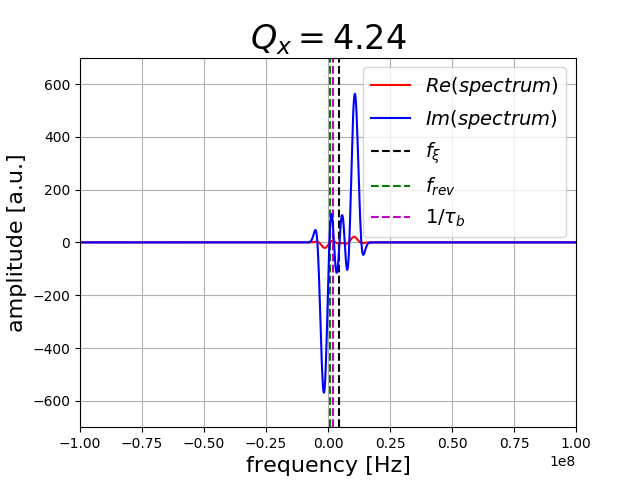

<IPython.core.display.Javascript object>


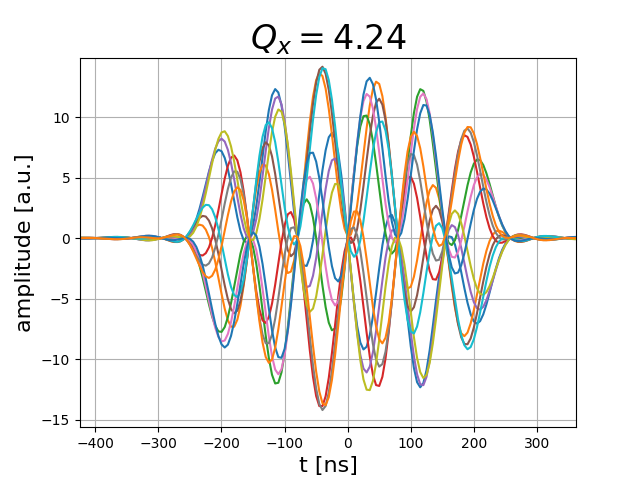

<IPython.core.display.Javascript object>


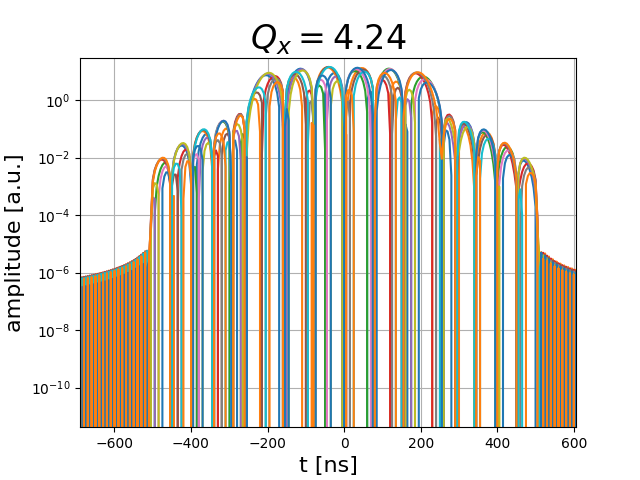

Text(0,0.5,'amplitude [a.u.]')

In [20]:
    #First plot shows the spectrum
    plt.figure()
    plt.xlim([-max(freq),max(freq)])
    ymax = max(ymax,round(100+np.max(np.hstack((np.real(lambda1tot),np.imag(lambda1tot)))),-2))
    ymin = min(ymin,round(-100+np.min(np.hstack((np.real(lambda1tot),np.imag(lambda1tot)))),-2))

    plt.plot(freq, np.real(lambda1tot), '-r',label=r"$Re(spectrum)$")
    plt.plot(freq, np.imag(lambda1tot), '-b',label=r"$Im(spectrum)$")
    plt.vlines([Qp*machine.omega0/(2.*np.pi*machine._eta)], ymin, ymax,
               linestyles='--',colors='k',label=r"$f_{{\xi}}$")
    plt.vlines([machine.omega0/(2.*np.pi)], ymin, ymax, linestyles='--',colors='g',label=r"$f_{{rev}}$")
    plt.vlines([1./taub], ymin, ymax, linestyles='--',colors='m',label=r"$1/\tau_b$")
    plt.ylim([ymin,ymax])
    plt.grid()
    plt.legend(loc=0,fontsize=14)
    plt.xlabel('frequency [Hz]',fontsize=16)
    plt.ylabel('amplitude [a.u.]',fontsize=16)
    plt.title(r"$Q_x={}$".format(Qx),fontsize=24)

    #Second plot shows a serie of signals
    plt.figure()        
    for signal in list_signals:
        plt.plot(times*1e9,signal, '-')

    plt.title(r"$Q_x={}$".format(Qx),fontsize=24)
    plt.grid()
    #plt.xlim(-40,40)
    #plt.xlabel('z [m]',fontsize=16)
    plt.xlabel('t [ns]',fontsize=16)
    plt.ylabel('amplitude [a.u.]',fontsize=16)
    #plt.xlim(-taub*1e9/2,taub*1e9/2)

    #Third plot shows a serie of signals, in semilogy
    plt.figure()        
    for signal in list_signals:
        plt.semilogy(times*1e9,signal, '-') #machine.beta*clight*times to get z


    plt.title(r"$Q_x={}$".format(Qx),fontsize=24)
    plt.grid()
    #plt.xlim(-40,40)
    #plt.xlabel('z [m]',fontsize=16)
    plt.xlabel('t [ns]',fontsize=16)
    plt.ylabel('amplitude [a.u.]',fontsize=16)
    #plt.xlim(-taub*1e9/2,taub*1e9/2)


### Plot rise times vs Qx

In [31]:
# PyHEADTAIL with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini, but GAUSSIAN)
qx = [4.17,  4.18,  4.19,  4.2 ,  4.22,  4.23,  4.24,  4.25,  4.26,
        4.27,  4.28,  4.29,  4.3 ,  4.31,  4.36,  4.37,  4.41,  4.42,
        4.43,  4.44,  4.45,  4.46,  4.47,  4.48]
tau = [2.94816758e+02,  -2.73927555e+03,  -2.52865266e+02,
         4.54159568e+01,   2.65136856e+01,   9.14142010e+00,
         3.43054562e+00,   1.13875757e+00,   5.20761672e-01,
         4.87766411e-01,   8.87470409e-01,   2.89201778e+00,
         7.03217664e+00,   1.48787595e+01,  -1.42901661e+02,
         9.32281186e+01,  -6.23087358e+01,  -2.96131931e+02,
         1.00062446e+02,  -1.45910813e+02,  -1.72731598e+03,
        -6.47571274e+01,   6.23678388e+01,   5.59967966e+01]
qx = np.array(qx)
tau = np.array(tau)

# DELPHI simulations with Rs = 4 MOhm/m, Q = 100, fr = 1.72 MHz (from Eirini, but GAUSSIAN)
qxD = [4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.30]
tauD = [11.45, 6.2, 2.65, 0.66, 0.61, 2.08, 5.13, 9.82]
qxD = np.array(qxD)
tauD = np.array(tauD)

msk = (tau<0) | (tau>50)

In [32]:
# plot rise times
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e3/(machine.omega0*dQ_imag),'b',lw=3,
         label=r"New DELPHI (flag_trapz={})".format(lab,flag_trapz))

#plt.plot(qx[~msk],tau[~msk],'r',marker='s',lw=3,ms=8,
#         label=r"PyHEADTAIL")

#plt.plot(qxD,tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab)) 
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Rise time [ms]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,20.])
plt.legend(fontsize=14)

# plot growth rates
fig = plt.figure()
fig.set_size_inches(10,7.5)

plt.plot(Qxscan,-1.e-3*(machine.omega0*dQ_imag),'b',lw=3,
         label=r"New DELPHI (flag_trapz={})".format(lab,flag_trapz))

#plt.plot(qx[~msk],1./tau[~msk],'r',marker='s',lw=3,ms=8,
#         label=r"PyHEADTAIL")

#plt.plot(qxD,1./tauD,'xg',lw=3,ms=8,label=r"{} DELPHI, Eirini's results".format(lab))
# to get (some of) these ones one needs Qp=-3.5


plt.ylabel(r"Growth rate [ms$^{{-1}}$]")
plt.xlabel(r"$Q_x$")
sciy(fig.gca())
set_fontsize(fig,18)
plt.grid()
plt.axis([4.23,4.32,0.,2.1])
plt.legend(fontsize=16)

<IPython.core.display.Javascript object>

NameError: name 'lab' is not defined